# Projet final du Kit Big Data 2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import multiprocessing
from bs4 import BeautifulSoup
from shutil import copyfileobj
from urllib import request
import time
import pylightxl as xl
import glob
import datetime
import re
import warnings
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse, accuracy_score as accuracy
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
warnings.filterwarnings('ignore')

## I - Acquisition et chargement des données

### 1.1. Acquisition des fichiers de classement

In [2]:
def download_excel(url, filename):
    ''' Télécharge le fichier Excel à l`URL donnée, et le stocke dans le fichier filename '''
    with request.urlopen(url) as response, open(filename, 'wb') as out_file:
        copyfileobj(response, out_file)

On remarque que les fichiers Excel contenant la liste des dates de classement sont disponibles sur la page principale du site https://www.vendeeglobe.org/fr/classement, et que le champ `value` des balises `option` contient le nom du fichier Excel de chaque classement. <br>
Pour récupérer l'ensemble des fichiers Excel, il suffit donc de récupérer les noms de fichier dans les tags option, puis de lancer une requête spécifique pour les télécharger.

In [3]:
html = requests.get("https://www.vendeeglobe.org/fr/classement").content.decode('utf-8')
soup = BeautifulSoup(html)
options = soup.findAll("option")
ranking_dates = []
for opt in options:
    if opt["value"]:
        ranking_dates.append(opt["value"])
print(f"{len(ranking_dates)} fichiers de classement trouvés.")

params = [(f"https://www.vendeeglobe.org/download-race-data/vendeeglobe_{date}.xlsx", f"vendeeglobe/{date}.xlsx") for date in ranking_dates]
with multiprocessing.Pool() as p:
    p.starmap(download_excel, params)

706 fichiers de classement trouvés.


Les fichiers ont été téléchargés en local, on cherche à présent à les importer dans deux Dataframe pandas : un pour les skippers encore en course, l'autre pour les skippers ayant déjà franchis la ligne d'arrivée.<br>Xlwings ne fonctionnant pas sur mon ordinateur, j'ai utilisé la library pylightxl pour pouvoir ouvrir les fichiers Excel et importer les données sous pandas.

In [4]:
def extract_running_data(datetime, db, row_start, row_stop):
    running = []
    headers = db.ws(ws="fr").row(row=row_start)[:-1]
    headers = [h.split("\n")[0] for h in headers]
    headers[0:4] = ["datetime", "rank", "Nat/Voile", "Skipper/Bateau"]
    headers[-1:] = ["DTF", "DTL"]
    headers[7:11] = [f"last30m_{h}" for h in headers[7:11]]
    headers[11:15] = [f"lastranking_{h}" for h in headers[11:15]]
    headers[15:19] = [f"last24h_{h}" for h in headers[15:19]]
    running.append(headers)
    for i in range(row_start+1, row_stop):
        skip = db.ws(ws="fr").row(row=i)[1:]
        skip.insert(0, datetime)
        running.append(skip)
    return running

In [5]:
def extract_finished_data(datetime, db, row_stop):
    finished = []
    headers = db.ws(ws="fr").row(row=5)
    headers = [h.split("\n")[0] for h in headers]
    headers[0:6] = ["datetime", "rank", "Nat/Voile", "Skipper/Bateau", "Date d'arrivée", "Temps de course"]
    headers[12:15:2] = [f"gap_{h}" for h in headers[12:15:2]]
    headers[16:18] = [f"ortho_{h}" for h in headers[16:18]]
    headers[18] = "percent"
    headers[19:21] = [f"ground_{h}" for h in headers[19:21]]
    headers = [h for h in headers if h]
    finished.append(headers)
    for i in range(6, row_stop):
        skip = db.ws(ws="fr").row(row=i)[1:]
        skip.insert(0, datetime)
        skip = [skip[idx] for idx in [0, 1, 2, 3, 7, 8, 13, 15, 16, 17, 18, 19, 20]]
        finished.append(skip)
    return finished

In [6]:
def extract_data(file):
    ''' Extracts data from Excel files and stores them into 2 lists of list'''
    with open(file, 'rb') as f:
        datetime = f.name.split(".")[0].split("/")[1]
        db = xl.readxl(f)
    # On compte le nombre de fois où "Rang" apparaît dans la colonne B
    B = db.ws(ws="fr").col(col=2)
    indices = [idx for idx, value in enumerate(B) if value == "Rang\nRank"]
    
    if datetime == "20201108_120200":
        #La course n'a pas encore commencé, aucune information utile dans ce fichier
        return [], []
    
    if len(indices) > 1 :
    # Cas où des skippers ont passé la ligne, mais il y a encore des skippers en course
        # Extract les données sur les skippers encore en course
        row_start = indices[1] + 2
        row_stop = B.index("Traitements et calculs : Géovoile, un service Hauwell Studios", row_start) + 1
        running = extract_running_data(datetime, db, row_start, row_stop)
        # Extract les données sur les skippers déjà arrivés
        finished = extract_finished_data(datetime, db, row_start-1)
    elif datetime == "20210305_080000":
    # Cas où tous les skippers sont arrivés (ou ont abandonné)
        running = []
        finished = extract_finished_data(datetime, db, 39)
    else:
    # Cas où aucun skipper n'a encore franchi la ligne d'arrivée
        finished = []
        running = extract_running_data(datetime, db, 5, 39)

    return finished, running

In [7]:
runnings, arrived = [], []
files = glob.glob("vendeeglobe/*")
for file in files:
    finished, running = extract_data(file)
    if finished:
        dff = pd.DataFrame(finished[1:], columns=finished[0])
        arrived.append(dff)
    if running:
        dfr = pd.DataFrame(running[1:], columns=running[0])
        runnings.append(dfr)

df_running = pd.concat(runnings)
df_finished = pd.concat(arrived)
print(f"Classement pour les skippers encore dans la course")
display(df_running.head())
print(f"Classement pour les skippers ayant franchis la ligne d'arrivée")
display(df_finished.head())

Classement pour les skippers encore dans la course


datetime rank   Nat/Voile                   Skipper/Bateau  \
0  20201230_110000    1    \nFRA 17  Yannick Bestaven\nMaître Coq IV   
1  20201230_110000    2    \nFRA 79            Charlie Dalin\nAPIVIA   
2  20201230_110000    3    \nFRA 59         Thomas Ruyant\nLinkedOut   
3  20201230_110000    4  \nFRA 1000     Damien Seguin\nGroupe APICIL   
4  20201230_110000    5    \nFRA 01        Jean Le Cam\nYes we Cam !   

     Heure FR    Latitude    Longitude last30m_Cap last30m_Vitesse  \
0  11:30 FR\n  55°47.17'S  110°11.00'W         78°        16.2 kts   
1  11:30 FR\n  53°47.14'S  112°32.49'W         85°        19.6 kts   
2  11:30 FR\n  54°12.00'S  114°10.44'W         89°        19.9 kts   
3  11:30 FR\n  54°58.86'S  114°41.63'W         90°        17.7 kts   
4  11:30 FR\n  54°58.66'S  116°27.85'W         95°         9.0 kts   

  last30m_VMG  ... lastranking_Cap lastranking_Vitesse lastranking_VMG  \
0    14.5 kts  ...             75°            17.1 kts        15.1 kts   
1    17.2 kts  ...             82°            21.3 kts        18.0 kts   
2    18.3 kts  ...             85°            19.4 kts        17.4 kts   
3    16.8 kts  ...             92°            17.3 kts        16.6 kts   
4     8.8 kts  ...             96°            10.1 kts         9.9 kts   

  lastranking_Distance last24h_Cap last24h_Vitesse last24h_VMG  \
0              51.4 nm        114°        12.1 kts    12.1 kts   
1              63.8 nm         85°        15.0 kts    12.8 kts   
2              58.3 nm         92°        15.6 kts    14.5 kts   
3              51.8 nm         93°        15.4 kts    14.6 kts   
4              30.4 nm         92°        14.0 kts    13.3 kts   

  last24h_Distance        DTF       DTL  
0         290.0 nm  8435.6 nm    0.0 nm  
1         360.9 nm  8553.0 nm  117.4 nm  
2         374.4 nm  8596.2 nm  160.6 nm  
3         369.6 nm  8596.8 nm  161.2 nm  
4         336.5 nm  8654.7 nm  219.1 nm  

[5 rows x 21 columns]

Classement pour les skippers ayant franchis la ligne d'arrivée


datetime    rank Nat/Voile  \
0  20210226_170000  1\nARV  \nFRA 17   
1  20210226_170000  2\nARV  \nFRA 79   
2  20210226_170000  3\nARV  \nFRA 18   
3  20210226_170000  4\nARV  \nFRA 01   
4  20210226_170000  5\nARV  \nMON 10   

                                      Skipper/Bateau          Date d'arrivée  \
0                    Yannick Bestaven\nMaître Coq IV  28/01/2021 04:19:46 FR   
1                              Charlie Dalin\nAPIVIA  27/01/2021 20:35:47 FR   
2                      Louis Burton\nBureau Vallée 2  28/01/2021 00:45:12 FR   
3                          Jean Le Cam\nYes we Cam !  28/01/2021 20:19:55 FR   
4  Boris Herrmann\nSeaexplorer - Yacht Club De Mo...  28/01/2021 11:19:45 FR   

                     Temps de course gap_Au premier gap_Au précédent  \
0  80j 03h 44min 46s\n-10h 15min 00s                                   
1                80j 06h 15min 47s\n  02h 31min 01s    02h 31min 01s   
2                80j 10h 25min 12s\n  06h 40min 26s    04h 09min 25s   
3  80j 13h 44min 55s\n-16h 15min 00s  10h 00min 09s    03h 19min 43s   
4  80j 14h 59min 45s\n-06h 00min 00s  11h 14min 59s    01h 14min 50s   

  ortho_Vitesse ortho_Distance  percent ground_Vitesse ground_Distance  
0      12.6 kts     24365.7 nm  117.3 %       14.8 kts      28583.8 nm  
1      12.6 kts     24365.7 nm  119.6 %       15.1 kts      29135.0 nm  
2      12.6 kts     24365.7 nm  117.6 %       14.8 kts      28650.0 nm  
3      12.5 kts     24365.7 nm  112.9 %       14.1 kts      27501.5 nm  
4      12.6 kts     24365.7 nm  116.8 %       14.7 kts      28448.5 nm

### 1.2. Acquisition des caractéristiques des bateaux

La page listant les caractéristiques des bateaux est https://www.vendeeglobe.org/fr/glossaire

In [8]:
html = requests.get("https://www.vendeeglobe.org/fr/glossaire").content.decode('utf-8')
soup = BeautifulSoup(html)
boats = []
popups = soup.findAll("div", attrs={"class": "sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6"})
for elem in popups:
    boat = {}
    boat["skipper_name"] = elem.find("span", attrs={"class": "boats-list__skipper-name"}).text
    skipper_id = elem.find_next("div", attrs={"class": "boats-list__popup mfp-hide"})["id"]
    boat["skipper_id"] = skipper_id.split("-")[-1]
    boat["Nom du bateau"] = elem.find_next('h3').text
    spec_list = elem.find_next('ul').find_all('li')
    for spec in spec_list:
        key, value = spec.text.split(":")[:2]
        if " / Assemblage" in value:
            value = value.split("/")[0]
        boat[key.strip()] = value.strip()
    boats.append(boat)
       
df_boats = pd.DataFrame(boats)
df_boats

skipper_name skipper_id                       Nom du bateau  \
0         Fabrice AMEDEO         93            NEWREST - ART & FENÊTRES   
1       Romain ATTANASIO        110                PURE - Best Western®   
2         Alexia BARRIER        100                    TSE -  4MYPLANET   
3       Yannick BESTAVEN         91                       Maître CoQ IV   
4          Jérémie BEYOU        103                              CHARAL   
5      Arnaud BOISSIÈRES         88   LA MIE CÂLINE - ARTISANS ARTIPÔLE   
6           Louis BURTON        106                     BUREAU VALLEE 2   
7            Didac COSTA        123                ONE PLANET ONE OCEAN   
8          Manuel COUSIN         92                        GROUPE SÉTIN   
9        Clarisse CREMER         95                  BANQUE POPULAIRE X   
10         Charlie DALIN        105                              APIVIA   
11            Sam DAVIES         97                   INITIATIVES-COEUR   
12   Sébastien DESTREMAU        117                               MERCI   
13      Benjamin DUTREUX        112                OMIA - WATER FAMILY    
14       Kevin ESCOFFIER         89                                 PRB   
15        Clément GIRAUD        114           Compagnie du Lit / Jiliti   
16     François Guiffant        129                                       
17              Pip HARE        120                            MEDALLIA   
18        Boris HERRMANN        109  SEAEXPLORER - YACHT CLUB DE MONACO   
19           Ari HUUSELA        124                               STARK   
20      Isabelle JOSCHKE        102                               MACSF   
21           Jean LE CAM        116                         Yes We Cam!   
22  Stéphane LE DIRAISON         94                     TIME FOR OCEANS   
23        Miranda MERRON        104                  CAMPAGNE DE FRANCE   
24      Giancarlo PEDOTE         96                      PRYSMIAN GROUP   
25           Alan  ROURA         99                         LA FABRIQUE   
26         Thomas RUYANT        113                           LinkedOut   
27         Damien SEGUIN        111                       GROUPE APICIL   
28      Kojiro SHIRAISHI        119                 DMG MORI Global One   
29       Sébastien SIMON         90                        ARKEA PAPREC   
30          Maxime SOREL        107                     V and B-MAYENNE   
31          Alex THOMSON        122                           HUGO BOSS   
32          Armel TRIPON        101              L'OCCITANE EN PROVENCE   
33      Nicolas TROUSSEL        108                     CORUM L'EPARGNE   

   Numéro de voile                             Anciens noms du bateau  \
0           FRA 56                     No Way Back, Vento di Sardegna   
1           FRA 49           Gitana Eighty, Synerciel, Newrest-Matmut   
2            FRA72  Famille Mary-Etamine du Lys, Initiatives Coeur...   
3               17                      Safran 2 - Des Voiles et Vous   
4               08                                                NaN   
5           FRA 14  Ecover3, Président, Gamesa, Kilcullen Voyager-...   
6               18                              Banque Populaire VIII   
7           ESP 33  Kingfisher - Educacion sin Fronteras - Forum M...   
8           FRA 71  Paprec-Virbac2, Estrella Damm, We are Water, L...   
9            FRA30                                        Macif - SMA   
10          FRA 79                                                NaN   
11          FRA109       Maître CoQ - Banque Populaire VII- Foncia II   
12              69              Foresight Natural Energy, Maisonneuve   
13           FRA09  Spirit of Yukoh, Neutrogena, Hugo Boss, Estrel...   
14          FRA 85                                                NaN   
15           FRA83  Delta Dore, Bureau Vallée, Vers un Monde sans ...   
16             NaN                                                NaN   
17           GBR77               Armor Lux, We Are Water, La Fabrique   

## II - Préparation des données 

### 2.1. Nettoyage des données de classement

In [9]:
def clean_ranking_running(df):
    # Formattage des dates
    df["datetime"] =  pd.to_datetime(df["datetime"], format="%Y%m%d_%H%M00")

    # Convertit le rang en chiffre pour pouvoir faire des moyennes dessus
    # Les valeurs non numériques pour les abandons / retards au départ sont converties en Nan
    df["rank"] = pd.to_numeric(df['rank'], errors="coerce").astype(float)
    
    # Séparation des nationalités et voiles
    # Le champ Nationalité est presque toujours vide et non utile, il n'est pas gardé
    df.insert(3, "Voile", df['Nat/Voile'].apply(lambda x: x.split("\n")[1]))

    # Séparation des skippers et bateaux
    df.insert(4, "Skipper", df['Skipper/Bateau'].apply(lambda x: x.split("\n")[0]))
    df.insert(5, "Bateau", df['Skipper/Bateau'].apply(lambda x: x.split("\n")[1]))
    df.drop(columns=['Nat/Voile', 'Skipper/Bateau', 'Heure FR'], inplace=True)

    # Conversion des coordonnées en valeurs décimales
    def convert_degrees(s):
        if s != "":
            degrees = re.split('[°\']', s)
            return (float(degrees[0]) + (float(degrees[1])/60)) * (-1 if degrees[2] == 'S' or degrees[2] == 'W' else 1)   
    df['Latitude'] = df['Latitude'].apply(convert_degrees)
    df['Longitude'] = df['Longitude'].apply(convert_degrees)

    # Conversion des grandeurs physiques en nombres
    for col in ['last30m_Cap', 'lastranking_Cap', 'last24h_Cap']:
        df[col] = df[col].astype(str).str[:-1].astype(float, errors="ignore")
    for col in ['last30m_Vitesse', 'lastranking_Vitesse', 'last24h_Vitesse',
                'last30m_VMG', 'lastranking_VMG', 'last24h_VMG',
                'last30m_Distance', 'lastranking_Distance', 'last24h_Distance',
                'DTF', 'DTL']:
        #df[col] = df[col].apply(lambda x: x.split(' ')[0]).astype(float, errors="ignore")
        df[col] = pd.to_numeric(df[col].apply(lambda x: x.split(' ')[0]), errors="coerce").astype(float)
    
    # Tri par ordre de dates et rang
    df = df.sort_values(by=["datetime", "rank"], ascending=[True,True], axis=0, ignore_index=True)
    
    return df    

In [10]:
df_running = clean_ranking_running(df_running)
df_running

datetime  rank    Voile           Skipper  \
0     2020-11-08 14:00:00   1.0   FRA 18      Louis Burton   
1     2020-11-08 14:00:00   2.0   MON 10    Boris Herrmann   
2     2020-11-08 14:00:00   3.0    FRA 8     Jérémie Beyou   
3     2020-11-08 14:00:00   4.0   FRA 59     Thomas Ruyant   
4     2020-11-08 14:00:00   5.0   FRA 53      Maxime Sorel   
...                   ...   ...      ...               ...   
19222 2021-03-05 04:00:00   NaN  FRA 109   Samantha Davies   
19223 2021-03-05 04:00:00   NaN    FRA 4   Sébastien Simon   
19224 2021-03-05 04:00:00   NaN   GBR 99      Alex Thomson   
19225 2021-03-05 04:00:00   NaN   FRA 85   Kevin Escoffier   
19226 2021-03-05 04:00:00   NaN    FRA 6  Nicolas Troussel   

                                   Bateau   Latitude  Longitude last30m_Cap  \
0                         Bureau Vallée 2  46.407667  -1.841333         241   
1      Seaexplorer - Yacht Club De Monaco  46.405667  -1.830333         241   
2                                  Charal  46.415167  -1.833167         244   
3                               LinkedOut  46.411833  -1.828000         244   
4                         V And B Mayenne  46.409833  -1.826000         246   
...                                   ...        ...        ...         ...   
19222                 Initiatives - Coeur        NaN        NaN               
19223                        ARKEA PAPREC        NaN        NaN               
19224                           HUGO BOSS        NaN        NaN               
19225                                 PRB        NaN        NaN               
19226                     CORUM L'Épargne        NaN        NaN               

       last30m_Vitesse  last30m_VMG  ...  lastranking_Cap lastranking_Vitesse  \
0                 17.7         17.5  ...              357                 0.0   
1                 11.1         10.9  ...              357                 0.0   
2                 15.5         15.5  ...              357                 0.0   
3                 13.2         13.1  ...              357                 0.0   
4                 10.9         10.9  ...              357                 0.0   
...                ...          ...  ...              ...                 ...   
19222              NaN          NaN  ...                                  NaN   
19223              NaN          NaN  ...                                  NaN   
19224              NaN          NaN  ...                                  NaN   
19225              NaN          NaN  ...                                  NaN   
19226              NaN          NaN  ...                                  NaN   

       lastranking_VMG  lastranking_Distance  last24h_Cap last24h_Vitesse  \
0                  0.0                2788.0          201             0.3   
1                  0.0                2787.9          196             0.3   
2                  0.0                2788.5          199             0.2   
3                  0.0                2788.3          196             0.2   
4                  0.0                2788.1          195             0.8   
...                ...                   ...          ...             ...   
19222              NaN                   NaN                          NaN   
19223              NaN                   NaN                          NaN   
19224              NaN                   NaN                          NaN   
19225              NaN                   NaN                          NaN   
19226              NaN                   NaN                          NaN   

       last24h_VMG  last24h_Distance      DTF  DTL  
0              0.3               6.1  24293.9  0.0  
1              0.2               6.0  24294.2  0.4  
2              0.2               5.5  24294.3  0.5  
3              0.2               5.6  24294.5  0.6  
4              0.7               5.8  24294.5  0.6  
...            ...               ...      ...  ...  
19222          NaN               NaN      NaN  NaN  
1

In [11]:
def clean_ranking_finished(df):
    # Formattage des dates
    df["datetime"] =  pd.to_datetime(df["datetime"], format="%Y%m%d_%H%M00")
    df["Date d'arrivée"] = df["Date d'arrivée"].apply(lambda x: pd.to_datetime(x.split(" FR")[0], format="%d/%m/%Y %H:%M:%S") if x!= "" else x)
    df["Temps de course"] = df["Temps de course"].apply(lambda x: x.split("\n")[0] if "\n" in x else x)

    # Séparation des rangs et statuts
    df.insert(1, "Rang", pd.to_numeric(df['rank'].apply(lambda x: x.split("\n")[0]), errors="coerce").astype(float))
    df.insert(2, "Statut", df['rank'].apply(lambda x: x.split("\n")[1] if "\n" in x else x))
    
    # Séparation des nationalités et voiles
    # Le champ Nationalité est presque toujours vide et non utile, il n'est pas gardé
    df.insert(3, "Voile", df['Nat/Voile'].apply(lambda x: x.split("\n")[1]))

    # Séparation des skippers et bateaux
    df.insert(4, "Skipper", df['Skipper/Bateau'].apply(lambda x: x.split("\n")[0]))
    df.insert(5, "Bateau", df['Skipper/Bateau'].apply(lambda x: x.split("\n")[1]))
    df.drop(columns=['rank', 'Nat/Voile', 'Skipper/Bateau'], inplace=True)

    # Conversion des grandeurs physiques en nombres
    for col in ['ortho_Vitesse', 'ortho_Distance', 'percent', 'ground_Vitesse', 'ground_Distance']:
        #df[col] = df[col].apply(lambda x: x.split(' ')[0]).astype(float, errors='ignore')
        df[col] = pd.to_numeric(df[col].apply(lambda x: x.split(' ')[0]), errors="coerce").astype(float)
    
    # Tri par ordre de dates et rang
    df = df.sort_values(by=["datetime", "Rang"], ascending=[True,True], axis=0, ignore_index=True)
    
    return df   

In [12]:
df_finished = clean_ranking_finished(df_finished)
df_finished

datetime  Rang Statut    Voile           Skipper  \
0    2021-01-27 17:00:00   1.0    ARV   FRA 79     Charlie Dalin   
1    2021-01-27 21:00:00   1.0    ARV   FRA 17  Yannick Bestaven   
2    2021-01-27 21:00:00   2.0    ARV   FRA 79     Charlie Dalin   
3    2021-01-27 21:00:00   3.0    ARV   FRA 18      Louis Burton   
4    2021-01-28 04:00:00   1.0    ARV   FRA 17  Yannick Bestaven   
...                  ...   ...    ...      ...               ...   
3934 2021-03-05 08:00:00   NaN    RET  FRA 109   Samantha Davies   
3935 2021-03-05 08:00:00   NaN    RET    FRA 4   Sébastien Simon   
3936 2021-03-05 08:00:00   NaN    RET   GBR 99      Alex Thomson   
3937 2021-03-05 08:00:00   NaN    RET   FRA 85   Kevin Escoffier   
3938 2021-03-05 08:00:00   NaN    RET    FRA 6  Nicolas Troussel   

                   Bateau      Date d'arrivée    Temps de course  \
0                  APIVIA 2021-01-27 21:35:47  80j 06h 15min 47s   
1           Maître Coq IV 2021-01-28 05:19:46  80j 03h 44min 46s   
2                  APIVIA 2021-01-27 21:35:47  80j 06h 15min 47s   
3         Bureau Vallée 2 2021-01-28 01:45:12  80j 10h 25min 12s   
4           Maître Coq IV 2021-01-28 05:19:46  80j 03h 44min 46s   
...                   ...                 ...                ...   
3934  Initiatives - Coeur                 NaT                      
3935         ARKEA PAPREC                 NaT                      
3936            HUGO BOSS                 NaT                      
3937                  PRB                 NaT                      
3938      CORUM L'Épargne                 NaT                      

     gap_Au premier gap_Au précédent  ortho_Vitesse  ortho_Distance  percent  \
0                                              12.6         24355.0    119.6   
1                                              12.6         24365.7    117.3   
2     02h 31min 01s    02h 31min 01s           12.6         24365.7    119.6   
3     06h 40min 26s    04h 09min 25s           12.6         24365.7    117.6   
4                                              12.6         24365.7    117.3   
...             ...              ...            ...             ...      ...   
3934                                            NaN             NaN      NaN   
3935                                            NaN             NaN      NaN   
3936                                            NaN             NaN      NaN   
3937                                            NaN             NaN      NaN   
3938                                            NaN             NaN      NaN   

      ground_Vitesse  ground_Distance  
0               15.1          29135.0  
1               14.8          28583.8  
2               15.1          29135.0  
3               14.8          28650.0  
4               14.8          28583.8  
...              ...              ...  
3934             NaN              NaN  
3935             NaN              NaN  
3936             NaN              NaN  
3937             NaN              NaN  
3938             NaN              NaN  

[3939 rows x 15 columns]

### 2.2. Nettoyage des caractéristiques des bateaux

Les noms des skippers ne sont pas orthographiés de la même manière entre les données de classement et de bateau. On les extrait des données de classement pour faire un mapping dessus dans la table des bateaux

In [13]:
skippers = df_finished["Skipper"].unique().tolist()
first_names = [name.split(" ")[0] for name in skippers]
names, counts = np.unique(first_names, return_counts=True)
print(f"Prénoms en double : {names[np.where(counts > 1)][0]}")

Prénoms en double : Sébastien


Seul le prénom Sébastien est en double, se baser sur les prénoms pour faire le mapping devrait donc se faire sans trop de problèmes.

Dans le dataframe des bateaux, un des bateaux n'a pas de numéro de voile. Peut-être peut-on le récupérer depuis le dataframe des classements

In [14]:
voiles = df_finished[["Skipper", "Voile"]]
voiles[voiles["Skipper"]=="Thomas Ruyant"].iloc[0]

Skipper    Thomas Ruyant
Voile             FRA 59
Name: 7, dtype: object

Le numéro de voile correspondant est donc FRA 59

Certains Nan sont présents dans des champs non utiles (ex: Anciens noms du bateau), ils ne sont donc pas nettoyés explicitement.

In [15]:
def clean_boats_features(df_boats, skipper_mapping):
    # Drop François Guiffant (seulement un nom, aucune caractéristique de bateau, n'intervient pas dans la course)
    df_boats = df_boats.drop(16).reset_index(drop=True)
    
    # Conversion des grandeurs physiques en nombres
    for col in ['Longueur', 'Largeur', 'Tirant d\'eau', 'Déplacement (poids)', 'Hauteur mât', 'Surface de voiles au près', 'Surface de voiles au portant']:
        df_boats[col] = df_boats[col].apply(lambda x: re.sub(' ?[A-Za-z]+[2²]?', '', x).replace(',', '.')).astype(float, errors='ignore')
    
    # Mapping des noms avec ceux des données de classement pour merge
    mapping = {}
    skippers = df_boats["skipper_name"].unique().tolist()
    for skip in skippers:
        if skip == "Sébastien DESTREMAU":
            mapping[skip] = "Sébastien Destremau"
        elif skip == "Sébastien SIMON":
            mapping[skip] = "Sébastien Simon"
        elif skip == "Sam DAVIES":
            mapping[skip] = "Samantha Davies"
        else:
            mapping[skip] = [name for name in skipper_mapping if name.split(" ")[0] == skip.split(" ")[0]][0]
    df_boats["skipper_name"] = df_boats["skipper_name"].map(mapping)
    df_boats[df_boats["skipper_name"] == "Thomas Ruyant"]["Numéro de voile"] = "FRA 59"
    
    # Fix foils bateau SIMON
    df_boats = df_boats.replace("foiler", "foils")
    
    return df_boats

In [16]:
df_boats = clean_boats_features(df_boats, skippers)
df_boats

skipper_name skipper_id                       Nom du bateau  \
0         Fabrice Amedeo         93            NEWREST - ART & FENÊTRES   
1       Romain Attanasio        110                PURE - Best Western®   
2         Alexia Barrier        100                    TSE -  4MYPLANET   
3       Yannick Bestaven         91                       Maître CoQ IV   
4          Jérémie Beyou        103                              CHARAL   
5      Arnaud Boissieres         88   LA MIE CÂLINE - ARTISANS ARTIPÔLE   
6           Louis Burton        106                     BUREAU VALLEE 2   
7            Didac Costa        123                ONE PLANET ONE OCEAN   
8          Manuel Cousin         92                        GROUPE SÉTIN   
9        Clarisse Cremer         95                  BANQUE POPULAIRE X   
10         Charlie Dalin        105                              APIVIA   
11       Samantha Davies         97                   INITIATIVES-COEUR   
12   Sébastien Destremau        117                               MERCI   
13      Benjamin Dutreux        112                OMIA - WATER FAMILY    
14       Kevin Escoffier         89                                 PRB   
15        Clément Giraud        114           Compagnie du Lit / Jiliti   
16              Pip Hare        120                            MEDALLIA   
17        Boris Herrmann        109  SEAEXPLORER - YACHT CLUB DE MONACO   
18           Ari Huusela        124                               STARK   
19      Isabelle Joschke        102                               MACSF   
20           Jean Le Cam        116                         Yes We Cam!   
21  Stéphane Le Diraison         94                     TIME FOR OCEANS   
22        Miranda Merron        104                  CAMPAGNE DE FRANCE   
23      Giancarlo Pedote         96                      PRYSMIAN GROUP   
24            Alan Roura         99                         LA FABRIQUE   
25         Thomas Ruyant        113                           LinkedOut   
26         Damien Seguin        111                       GROUPE APICIL   
27      Kojiro Shiraishi        119                 DMG MORI Global One   
28       Sébastien Simon         90                        ARKEA PAPREC   
29          Maxime Sorel        107                     V and B-MAYENNE   
30          Alex Thomson        122                           HUGO BOSS   
31          Armel Tripon        101              L'OCCITANE EN PROVENCE   
32      Nicolas Troussel        108                     CORUM L'EPARGNE   

   Numéro de voile                             Anciens noms du bateau  \
0           FRA 56                     No Way Back, Vento di Sardegna   
1           FRA 49           Gitana Eighty, Synerciel, Newrest-Matmut   
2            FRA72  Famille Mary-Etamine du Lys, Initiatives Coeur...   
3               17                      Safran 2 - Des Voiles et Vous   
4               08                                                NaN   
5           FRA 14  Ecover3, Président, Gamesa, Kilcullen Voyager-...   
6               18                              Banque Populaire VIII   
7           ESP 33  Kingfisher - Educacion sin Fronteras - Forum M...   
8           FRA 71  Paprec-Virbac2, Estrella Damm, We are Water, L...   
9            FRA30                                        Macif - SMA   
10          FRA 79                                                NaN   
11          FRA109       Maître CoQ - Banque Populaire VII- Foncia II   
12              69              Foresight Natural Energy, Maisonneuve   
13           FRA09  Spirit of Yukoh, Neutrogena, Hugo Boss, Estrel...   
14          FRA 85                                                NaN   
15           FRA83  Delta Dore, Bureau Vallée, Vers un Monde sans ...   
16           GBR77               Armor Lux, We Are Water, La Fabrique   
17              16  Edmond de Rothschild, Malizia - Yacht Club de ...   
18          FIN222                      Aviva, GAES Centros Auditivos   
1

### 2.3. Rapprochement des données des voiliers avec celle des classements

Nous pouvons à présent combiner les dataframes des caractéristiques de bateau et de classement grâce au nom de skipper.

In [17]:
merge_df = pd.merge(left=df_running, right=df_boats, left_on="Skipper", right_on="skipper_name", how="left")
merge_df.drop(columns=['skipper_name', "Bateau"], inplace=True)
merge_df

datetime  rank    Voile           Skipper   Latitude  \
0     2020-11-08 14:00:00   1.0   FRA 18      Louis Burton  46.407667   
1     2020-11-08 14:00:00   2.0   MON 10    Boris Herrmann  46.405667   
2     2020-11-08 14:00:00   3.0    FRA 8     Jérémie Beyou  46.415167   
3     2020-11-08 14:00:00   4.0   FRA 59     Thomas Ruyant  46.411833   
4     2020-11-08 14:00:00   5.0   FRA 53      Maxime Sorel  46.409833   
...                   ...   ...      ...               ...        ...   
19222 2021-03-05 04:00:00   NaN  FRA 109   Samantha Davies        NaN   
19223 2021-03-05 04:00:00   NaN    FRA 4   Sébastien Simon        NaN   
19224 2021-03-05 04:00:00   NaN   GBR 99      Alex Thomson        NaN   
19225 2021-03-05 04:00:00   NaN   FRA 85   Kevin Escoffier        NaN   
19226 2021-03-05 04:00:00   NaN    FRA 6  Nicolas Troussel        NaN   

       Longitude last30m_Cap  last30m_Vitesse  last30m_VMG  last30m_Distance  \
0      -1.841333         241             17.7         17.5               0.3   
1      -1.830333         241             11.1         10.9               0.4   
2      -1.833167         244             15.5         15.5               0.5   
3      -1.828000         244             13.2         13.1               0.7   
4      -1.826000         246             10.9         10.9               0.2   
...          ...         ...              ...          ...               ...   
19222        NaN                          NaN          NaN               NaN   
19223        NaN                          NaN          NaN               NaN   
19224        NaN                          NaN          NaN               NaN   
19225        NaN                          NaN          NaN               NaN   
19226        NaN                          NaN          NaN               NaN   

       ...  Date de lancement  Longueur  Largeur  Tirant d'eau  \
0      ...       09 Juin 2015     18.28     5.80           4.5   
1      ...       07 Août 2015     18.28     5.70           4.5   
2      ...       18 Août 2018     18.28     5.85           4.5   
3      ...  03 Septembre 2019     18.28     5.85           4.5   
4      ...  07 Septembre 2007     18.28     5.50           4.5   
...    ...                ...       ...      ...           ...   
19222  ...  20 Septembre 2010     18.28     5.70           4.5   
19223  ...    19 Juillet 2019     18.28     5.70           4.5   
19224  ...       15 Août 2019     18.28     5.40           4.5   
19225  ...       08 Mars 2010     18.28     5.50           4.5   
19226  ...        15 Mai 2020     18.28     5.70           4.5   

      Déplacement (poids)  Nombre de dérives  Hauteur mât        Voile quille  \
0                     7.6              foils         28.0               acier   
1                     7.6              foils         29.0               acier   
2                       8              foils         29.0               acier   
3                       8              foils         29.0         acier forgé   
4                     7.7                  2         29.0               acier   
...                   ...                ...          ...                 ...   
19222                 7.8              foils         27.0         acier forgé   
19223                   8              foils         29.0          Inox usiné   
19224                 7.7              foils         29.0         acier forgé   
19225                                  foils         27.4  Acier mécano soudé   
19226                 7.9              foils         27.3                 NaN   

       Surface de voiles au près  Surface de voiles au portant  
0                          300.0                         600.0  
1                          290.0                         490.0  
2                          320.0                         600.0  
3                          350.0                         560.0  
4                          365.0                         700.0  
...                    

## III - Analyses et story telling

### 3.1. Visualisation du classement final

Il est possible d'afficher le classement final en récupérant les 33 dernières lignes du dataframe contenant les skipper ayant franchi la ligne d'arrivée. Les rang affichés en `Nan` correspondent aux abandons. <br>
<u>N.B.</u> : Le classement final ne correspond pas exactement à l'ordre d'arrivée des skippers, certains temps de compensation ayant été accordés.

In [18]:
final_rank = df_finished[-33:][["Date d'arrivée", "Rang", "Skipper"]].reset_index(drop=True)
final_rank

Date d'arrivée  Rang               Skipper
0  2021-01-28 04:19:46   1.0      Yannick Bestaven
1  2021-01-27 20:35:47   2.0         Charlie Dalin
2  2021-01-28 00:45:12   3.0          Louis Burton
3  2021-01-28 20:19:55   4.0           Jean Le Cam
4  2021-01-28 11:19:45   5.0        Boris Herrmann
5  2021-01-28 05:42:01   6.0         Thomas Ruyant
6  2021-01-28 12:18:20   7.0         Damien Seguin
7  2021-01-28 13:02:20   8.0      Giancarlo Pedote
8  2021-01-29 10:05:20   9.0      Benjamin Dutreux
9  2021-01-30 04:50:15  10.0          Maxime Sorel
10 2021-02-01 07:27:50  11.0          Armel Tripon
11 2021-02-03 16:44:25  12.0       Clarisse Cremer
12 2021-02-06 09:15:58  13.0         Jérémie Beyou
13 2021-02-06 17:06:02  14.0      Romain Attanasio
14 2021-02-11 08:56:06  15.0     Arnaud Boissieres
15 2021-02-11 11:52:56  16.0      Kojiro Shiraishi
16 2021-02-11 20:29:56  17.0            Alan Roura
17 2021-02-11 22:36:00  18.0  Stéphane Le Diraison
18 2021-02-12 01:57:30  19.0              Pip Hare
19 2021-02-13 20:47:03  20.0           Didac Costa
20 2021-02-16 10:28:31  21.0        Clément Giraud
21 2021-02-17 23:16:51  22.0        Miranda Merron
22 2021-02-20 08:35:40  23.0         Manuel Cousin
23 2021-02-28 07:23:44  24.0        Alexia Barrier
24 2021-03-05 08:35:46  25.0           Ari Huusela
25                 NaT   NaN   Sébastien Destremau
26                 NaT   NaN      Isabelle Joschke
27                 NaT   NaN        Fabrice Amedeo
28                 NaT   NaN       Samantha Davies
29                 NaT   NaN       Sébastien Simon
30                 NaT   NaN          Alex Thomson
31                 NaT   NaN       Kevin Escoffier
32                 NaT   NaN      Nicolas Troussel

### 3.2. Route des voiliers

A partir des données récupérées, il est à présent possible d'afficher la route de chacun des voiliers pendant la course.

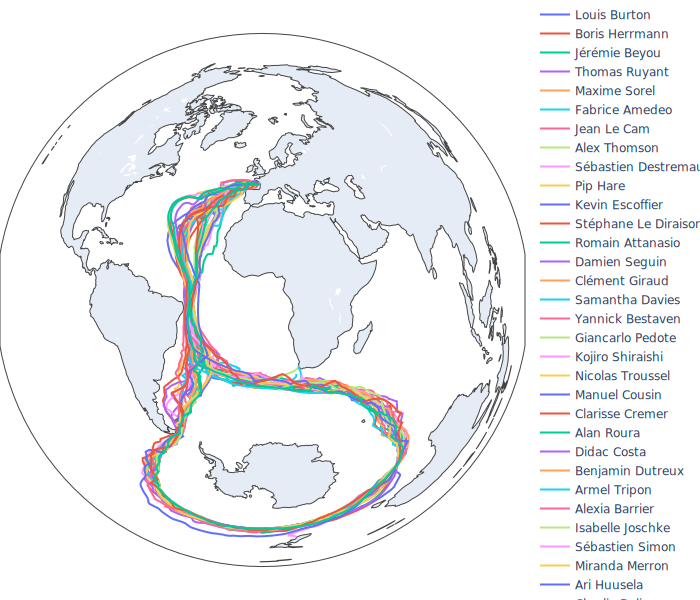

In [19]:
fig = go.Figure()

df_skippers = []
for skipper in df_running["Skipper"].unique():
    df_skippers.append(df_running[df_running["Skipper"] == skipper])
for df in df_skippers:
    fig = fig.add_trace(go.Scattergeo(        
        lon = df['Longitude'],
        lat = df['Latitude'],
        text = df['datetime'].astype('str') + " : Classement " + df['rank'].astype('str'),
        mode="lines",
        name=df["Skipper"].unique()[0]))
fig.update_geos(projection_type="azimuthal equal area", fitbounds="locations")
fig.update_layout(height=600, margin={"r":0,"t":0,"l":0,"b":0})
fig.show("svg")

Cet affichage permet notamment de repérer l'abandon de certains skippers (Sébastien Destremeau qui s'arrête en Nouvelle-Zélande, Alex Thomson et Samantha Davies qui s'arrêtent au Cap de Bonne-Espérance, etc.)

En zoomant au sud du Cap de Bonne-Espérance, il est également possible d'observer le changement de cap de Yannick Bestaven (en bleu ci-dessou), qui a modifié sa trajectoire pour porter assistance à Kevin Escoffier (en rouge ci-dessous). <br>
Par comparaison, Charlie Davin (en cyan) a maintenu son cap et terminé la course avant Yannick Bestaven. Un temps de compensation a par la suite été accordé à Yannick Bestaven pour le sauvetage, ce qui lui a permis de terminer 1er au classement.

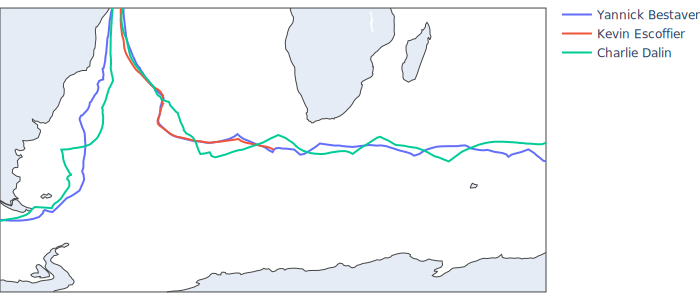

In [88]:
fig = go.Figure()
df_skippers_shortlist = []
for skipper in ["Yannick Bestaven", "Kevin Escoffier", "Charlie Dalin"]:
    df_skippers_shortlist.append(df_running[df_running["Skipper"] == skipper])
for df in df_skippers_shortlist:
    fig = fig.add_trace(go.Scattergeo(        
        lon = df['Longitude'],
        lat = df['Latitude'],
        text = df['datetime'].astype('str') + " : Classement " + df['rank'].astype('str'),
        mode="lines",
        name=df["Skipper"].unique()[0]))
fig.update_geos(projection_type="natural earth", center=dict(lat=-41, lon=9), projection_scale=2.5)
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
fig.show("svg")

Il est également possible de visualiser les différences d'optimisation du trajet de chaque skipper. Sur la carte ci-dessous, on peut observer qu'Alan Roura (en cyan ci-dessou) a énormément dévié vers le continent américain sur le retour, et a donc parcouru beaucoup une distance total beaucoup plus importante que Maxime Sorel (en rouge ci-dessou) par exemple.

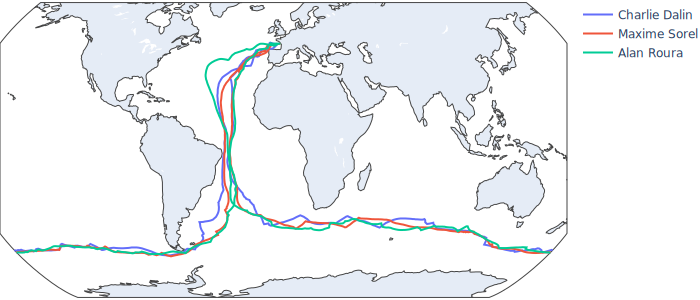

In [91]:
fig = go.Figure()
df_skippers_shortlist = []
for skipper in ["Charlie Dalin", "Maxime Sorel", "Alan Roura"]:
    df_skippers_shortlist.append(df_running[df_running["Skipper"] == skipper])
for df in df_skippers_shortlist:
    fig = fig.add_trace(go.Scattergeo(        
        lon = df['Longitude'],
        lat = df['Latitude'],
        text = df['datetime'].astype('str') + " : Classement " + df['rank'].astype('str'),
        mode="lines",
        name=df["Skipper"].unique()[0]))
fig.update_geos(projection_type="natural earth", fitbounds="locations")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
fig.show("svg")

### 3.3. Evolution du classement

A partir des données des skippers encore en course, il est également possible de visualiser l'évolution du classement des skippers, ainsi que les dates des abandons. On remarque une grande variabilité des classements en début de course, mais la liste des skippers faisant partie du top 10 semble déjà être déterminée à partir du premier mois de course.

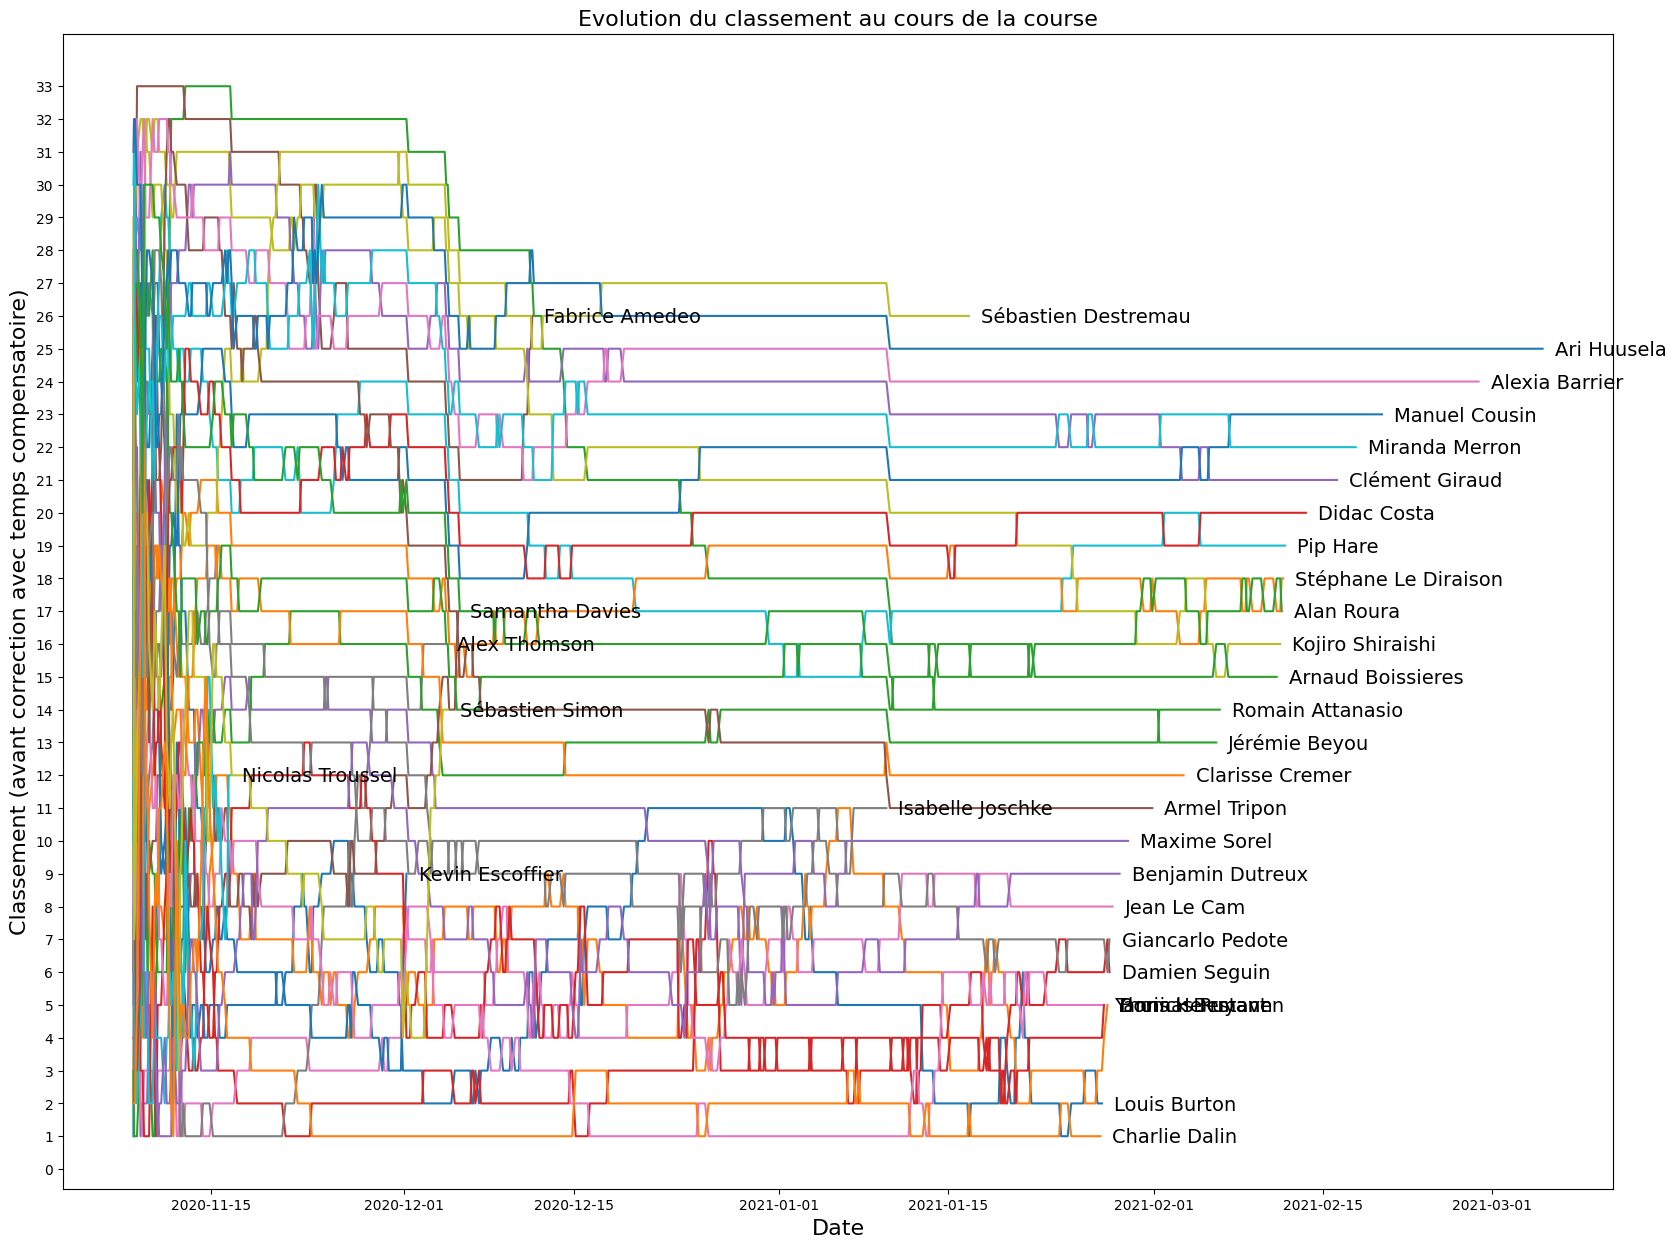

In [22]:
plt.figure(figsize=(20, 15))
for df in df_skippers:
    df = df.dropna()
    plt.plot(df["datetime"], df["rank"])
    plt.text(df.iloc[-1]["datetime"] + pd.Timedelta(days=1), df.iloc[-1]["rank"]-0.2,
             df["Skipper"].tolist()[0], fontsize=14)

plt.title('Evolution du classement au cours de la course', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Classement (avant correction avec temps compensatoire)', fontsize=16)
plt.yticks(range(34))
plt.show()

### 3.4. Distance parcourue par voilier

Il est également intéressant de regarder la distance totale parcourue par chaque skipper au long de la course.

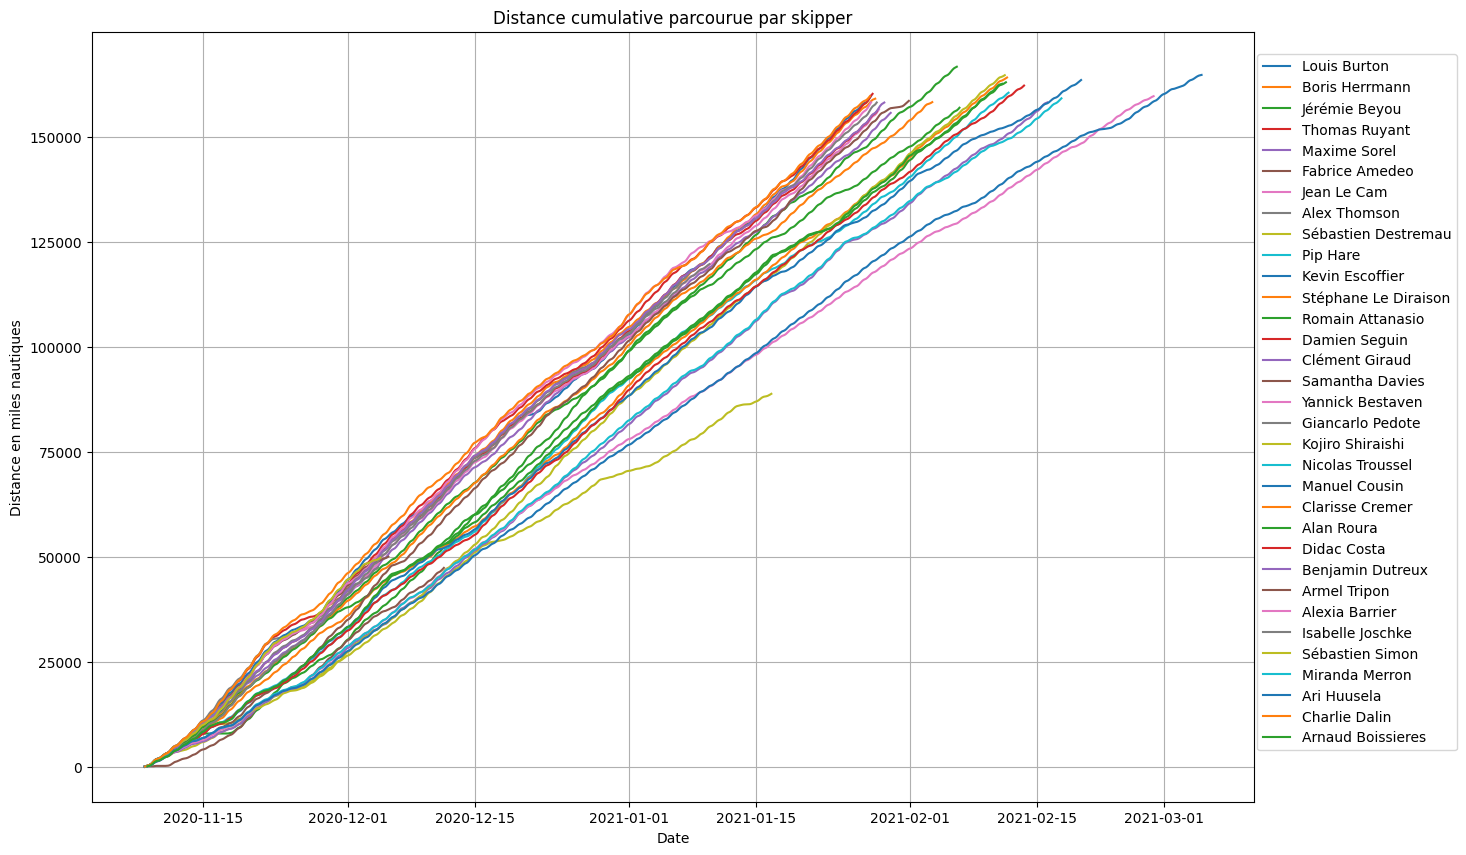

In [23]:
plt.figure(figsize=(15, 10))
for df in df_skippers:
    plt.plot(df["datetime"], df["last24h_Distance"].cumsum(), label=df["Skipper"].tolist()[0])

plt.legend(bbox_to_anchor=(1.18,0.98))
plt.grid(True, 'major', 'both')
plt.title('Distance cumulative parcourue par skipper')
plt.xlabel('Date')
plt.ylabel('Distance en miles nautiques')
plt.show()

On retrouve bien les observations faites sur la dernière carte présentée plus haut, à savoir que certains skippers comme Alan Roura ont parcouru des distances beaucoup plus importantes pour arriver à la ligne d'arrivée (ce qui impacte logiquement leur classement).

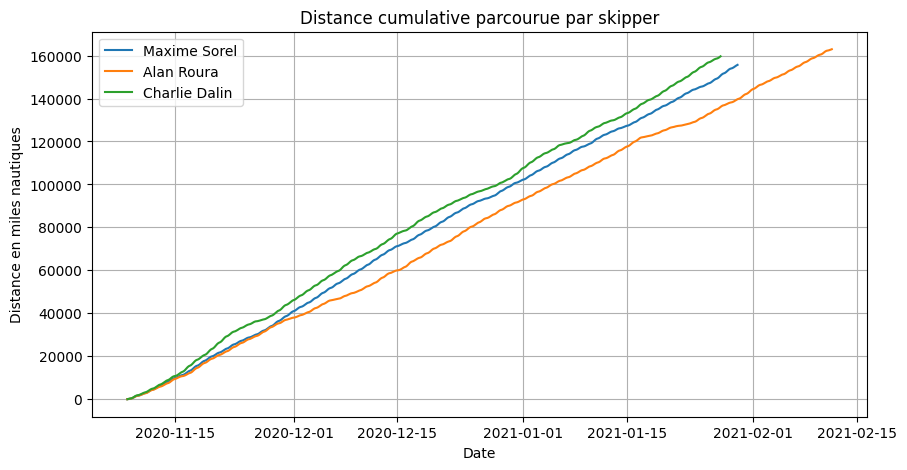

In [24]:
plt.figure(figsize=(10, 5))
for df in df_skippers:
    if df["Skipper"].tolist()[0] in ["Charlie Dalin", "Maxime Sorel", "Alan Roura"]:
        plt.plot(df["datetime"], df["last24h_Distance"].cumsum(), label=df["Skipper"].tolist()[0])

plt.legend()
plt.grid(True, 'major', 'both')
plt.title('Distance cumulative parcourue par skipper')
plt.xlabel('Date')
plt.ylabel('Distance en miles nautiques')
plt.show()

### 3.5. Analyse des performances

Après ces premières observations, il est à présent intéressant de se pencher sur les facteurs impactant le plus le classement final. On étudiera l'impact de la vitesse utile (VMG) des voiliers, et l'impact de la présence de foils sur le classement.

#### 3.5.1. Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

On calcule la VMG moyenne pour chaque skipper à partir des données relevées toutes les 24h pour effectuer une régression linéaire entre le classement et la VMG. Les données de VMG fournies par classement ne sont pas utilisées, car elles ne sont pas obtenues à des intervalles de temps constants.

In [25]:
df_moyennes = df_running.groupby("Skipper").mean()
df_moyennes.drop(columns=["Latitude", "Longitude", "last30m_Vitesse", "last30m_VMG", "last30m_Distance",
                          "last30m_Vitesse", "lastranking_Vitesse", "lastranking_VMG", "lastranking_Distance",
                          "lastranking_Vitesse"], inplace=True)
df_moyennes.rename(columns={"last24h_Vitesse": "Vitesse Moyenne", "last24h_VMG": "VMG Moyenne", "last24h_Distance":"Distance Moyenne", "rank": "Classement moyen"}, inplace=True)
df_moyennes

Classement moyen  Vitesse Moyenne  VMG Moyenne  \
Skipper                                                                
Alan Roura                   16.466783        11.870455    10.641608   
Alex Thomson                  7.461538        12.698718    10.966667   
Alexia Barrier               24.819403         9.940000     9.077015   
Ari Huusela                  25.955777         9.788873     8.673752   
Armel Tripon                 16.076772        13.003150    11.930118   
Arnaud Boissieres            17.452297        11.969788    10.724558   
Benjamin Dutreux              7.572301        13.424644    12.376986   
Boris Herrmann                6.921649        13.664124    12.542268   
Charlie Dalin                 2.286902        13.828898    12.604990   
Clarisse Cremer              13.508604        12.624665    11.652199   
Clément Giraud               24.295492        11.000835    10.073957   
Damien Seguin                 6.382716        13.376337    12.493827   
Didac Costa                  19.964041        11.585445    10.358904   
Fabrice Amedeo               26.965000         9.860500     8.594000   
Giancarlo Pedote             10.423868        13.558642    12.516461   
Isabelle Joschke             11.510638        13.260638    12.247340   
Jean Le Cam                   5.629098        13.364754    12.408402   
Jérémie Beyou                21.430427        12.884972    11.228015   
Kevin Escoffier               5.846715        13.644526    12.180292   
Kojiro Shiraishi             22.084063        12.014536    10.595972   
Louis Burton                  6.809524        13.774741    12.580952   
Manuel Cousin                21.302251        10.951286     9.707395   
Maxime Sorel                 10.659274        13.094960    12.246371   
Miranda Merron               23.522167        10.888013     9.932512   
Nicolas Troussel              7.260000        11.238000     9.376000   
Pip Hare                     19.221254        11.649826    10.537805   
Romain Attanasio             13.415896        12.082440    11.196673   
Samantha Davies              10.337423        12.824540    10.688344   
Stéphane Le Diraison         17.818499        11.932810    10.596684   
Sébastien Destremau          27.872902         8.872182     7.811031   
Sébastien Simon              10.398734        13.120886    11.296835   
Thomas Ruyant                 3.524793        13.796281    12.539256   
Yannick Bestaven              4.374741        13.644306    12.527329   

                      Distance Moyenne           DTF          DTL  
Skipper                                                            
Alan Roura                  284.864510  12010.866608  1805.306294  
Alex Thomson                304.442949  20795.096154   336.194231  
Alexia Barrier              238.259403  12213.304627  3417.251493  
Ari Huusela                 234.952211  11909.323966  3480.116262  
Armel Tripon                312.056496  12658.633268  1227.416929  
Arnaud Boissieres           287.263604  12175.901060  1990.906890  
Benjamin Dutreux            322.044196  12213.708758   397.569857  
Boris Herrmann              327.923093  12291.379588   330.507629  
Charlie Dalin               331.893971  12072.658004    63.314137  
Clarisse Cremer             302.536711  12036.986042   924.411855  
Clément Giraud              264.040067  12751.698998  2991.381970  
Damien Seguin               320.936420  12267.142387   330.776337  
Didac Costa                 277.675171  12245.223116  2245.323459  
Fabrice Amedeo              236.703500  21319.035500  2020.559000  
Giancarlo Pedote            325.390329  12385.792593   449.426955  
Isabelle Joschke            318.225266  15182.419415   531.471809  
Jean Le Cam                 320.729303  12223.731557   335.812705  
Jérémie Beyou               309.184045  13378.487570  2581.681447  
Kevin Escoffier             327.411679  21178.533577   230.286131  
Kojiro Shiraishi            288.328196  12782.084238  2558.718039  
Louis

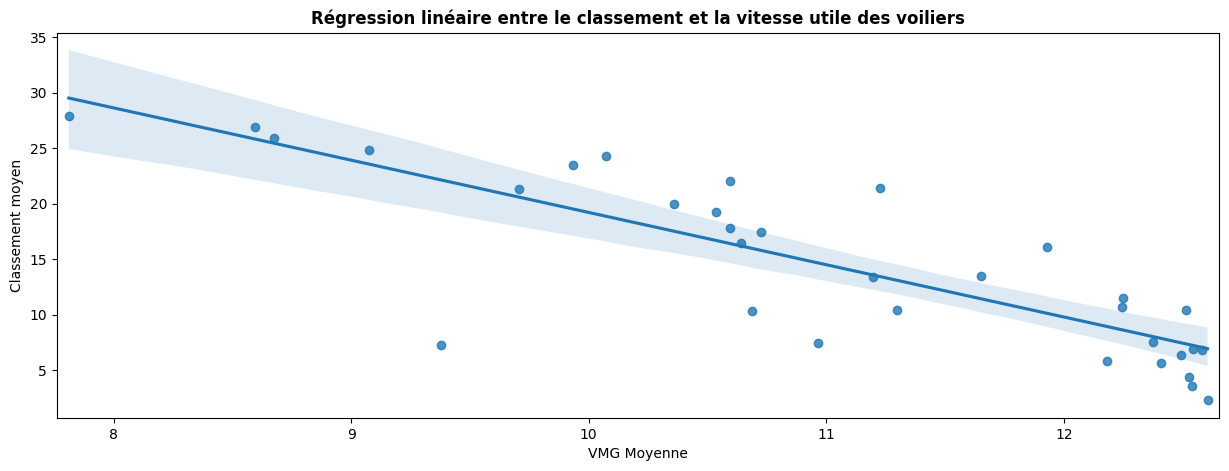

In [26]:
plt.figure(figsize=(15, 5))
linreg = sns.regplot(x = "VMG Moyenne", y = "Classement moyen", data = df_moyennes)
plt.title("Régression linéaire entre le classement et la vitesse utile des voiliers", fontweight='bold')
plt.xlim([df_moyennes["VMG Moyenne"].min()-0.05, df_moyennes["VMG Moyenne"].max()+0.05])
plt.show()

Les paramètres de cette droite de régression sont les suivants :

In [27]:
slope, intercept, r_value, p_value, std_err =  stats.linregress(x=linreg.get_lines()[0].get_xdata(),y=linreg.get_lines()[0].get_ydata())
reg = pd.DataFrame(columns=["Pente", "Ordonnée à l'origine", "r_value", "p_value", "Ecart-type"])
reg.loc[len(reg)] = [slope, intercept, r_value, p_value, std_err]
reg

Pente  Ordonnée à l'origine  r_value  p_value    Ecart-type
0 -4.713204              66.34955     -1.0      0.0  1.003317e-08

In [28]:
coeff = np.corrcoef(df_moyennes["VMG Moyenne"], df_moyennes["Classement moyen"])[0][1]
print(f"Le coefficient de corrélation entre le classement et la VMG est de {coeff:.2f}")

Le coefficient de corrélation entre le classement et la VMG est de -0.83


Il existe donc bien une forte corrélation entre classement et vitesse utile. Les skippers avec le meilleur classement sont ceux qui ont la plus grande vitesse utile, en moyenne.

#### 3.5.2 Impact de la présence d'un foil sur le classement et la vitesse des voiliers

Pour mesurer l'impact des foils, on sépare le jeu de données en 2 groupes : skippers avec foils, et skippers sans foil. Pour chacun des groupes, on va traver la distribution des classements moyens et des VMG moyennes pour conclure.

In [29]:
moyennes_merge_df = pd.merge(left=df_moyennes, right=df_boats, left_on="Skipper", right_on="skipper_name", how="left")
moyennes_merge_df = moyennes_merge_df.replace("2 asymétriques", "2")
moyennes_merge_df

Classement moyen  Vitesse Moyenne  VMG Moyenne  Distance Moyenne  \
0          16.466783        11.870455    10.641608        284.864510   
1           7.461538        12.698718    10.966667        304.442949   
2          24.819403         9.940000     9.077015        238.259403   
3          25.955777         9.788873     8.673752        234.952211   
4          16.076772        13.003150    11.930118        312.056496   
5          17.452297        11.969788    10.724558        287.263604   
6           7.572301        13.424644    12.376986        322.044196   
7           6.921649        13.664124    12.542268        327.923093   
8           2.286902        13.828898    12.604990        331.893971   
9          13.508604        12.624665    11.652199        302.536711   
10         24.295492        11.000835    10.073957        264.040067   
11          6.382716        13.376337    12.493827        320.936420   
12         19.964041        11.585445    10.358904        277.675171   
13         26.965000         9.860500     8.594000        236.703500   
14         10.423868        13.558642    12.516461        325.390329   
15         11.510638        13.260638    12.247340        318.225266   
16          5.629098        13.364754    12.408402        320.729303   
17         21.430427        12.884972    11.228015        309.184045   
18          5.846715        13.644526    12.180292        327.411679   
19         22.084063        12.014536    10.595972        288.328196   
20          6.809524        13.774741    12.580952        330.648447   
21         21.302251        10.951286     9.707395        262.840675   
22         10.659274        13.094960    12.246371        313.839919   
23         23.522167        10.888013     9.932512        261.288670   
24          7.260000        11.238000     9.376000        269.396000   
25         19.221254        11.649826    10.537805        279.559582   
26         13.415896        12.082440    11.196673        289.994085   
27         10.337423        12.824540    10.688344        306.887117   
28         17.818499        11.932810    10.596684        286.359860   
29         27.872902         8.872182     7.811031        212.909353   
30         10.398734        13.120886    11.296835        314.924684   
31          3.524793        13.796281    12.539256        330.988017   
32          4.374741        13.644306    12.527329        327.464803   

             DTF          DTL          skipper_name skipper_id  \
0   12010.866608  1805.306294            Alan Roura         99   
1   20795.096154   336.194231          Alex Thomson        122   
2   12213.304627  3417.251493        Alexia Barrier        100   
3   11909.323966  3480.116262           Ari Huusela        124   
4   12658.633268  1227.416929          Armel Tripon        101   
5   12175.901060  1990.906890     Arnaud Boissieres         88   
6   12213.708758   397.569857      Benjamin Dutreux        112   
7   12291.379588   330.507629        Boris Herrmann        109   
8   12072.658004    63.314137         Charlie Dalin        105   
9   12036.986042   924.411855       Clarisse Cremer         95   
10  12751.698998  2991.381970        Clément Giraud        114   
11  12267.142387   330.776337         Damien Seguin        111   
12  12245.223116  2245.323459           Didac Costa        123   
13  21319.035500  2020.559000        Fabrice Amedeo         93   
14  12385.792593   449.426955      Giancarlo Pedote         96   
15  15182.419415   531.471809      Isabelle Joschke        102   
16  12223.731557   335.812705           Jean Le Cam        116   
17  13378.487570  2581.681447         Jérémie Beyou        103   
18  21178.533577   230.286131       Kevin Escoffier         89   
19  12782.084238  2558.718039      Kojiro Shiraishi        119   
20  12338.296273   328.187992          Louis Burton        106   
21  11895.654019  2485.311897         Manuel Cousin         92   
22  12282.564718   583.285887        

In [30]:
foils = moyennes_merge_df[moyennes_merge_df["Nombre de dérives"] == "foils"]
no_foil = moyennes_merge_df[moyennes_merge_df["Nombre de dérives"] != "foils"]

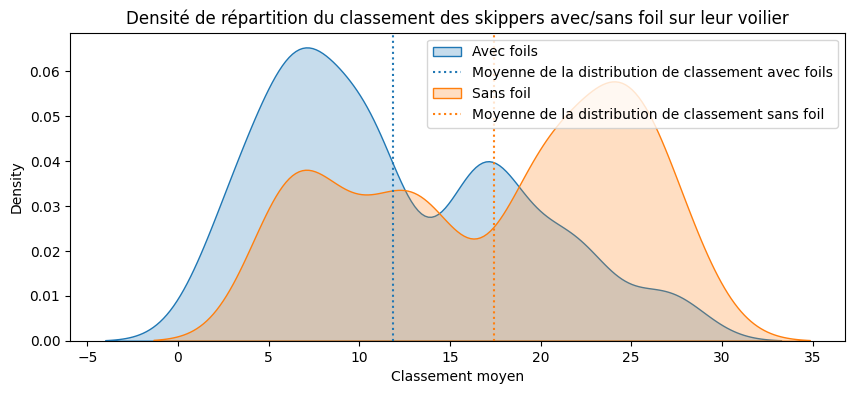

In [31]:
plt.figure(figsize=(10, 4))
sns.kdeplot(foils["Classement moyen"], bw=0.3, label="Avec foils", fill=True)
plt.axvline(x = foils['Classement moyen'].mean(), color = 'C0', label ="Moyenne de la distribution de classement avec foils", linestyle="dotted")
sns.kdeplot(no_foil["Classement moyen"], bw=0.3, label="Sans foil", fill=True)
plt.axvline(x = no_foil['Classement moyen'].mean(), color = 'C1', label ="Moyenne de la distribution de classement sans foil", linestyle="dotted")
plt.title("Densité de répartition du classement des skippers avec/sans foil sur leur voilier")
plt.legend()
plt.show()

Valeurs numériques

In [32]:
print(f"Classement moyen avec foils         : {foils['Classement moyen'].mean():.2f}")
print(f"Classement moyen sans foil          : {no_foil['Classement moyen'].mean():.2f}")
print(f"Ecart-type du classement avec foils : {foils['Classement moyen'].std():.2f}")
print(f"Ecart-type du classement sans foil  : {no_foil['Classement moyen'].std():.2f}")

Classement moyen avec foils         : 11.87
Classement moyen sans foil          : 17.44
Ecart-type du classement avec foils : 6.99
Ecart-type du classement sans foil  : 7.75


On remarque donc, qu'à dispertion similaire, le classement moyen des skippers avec foils est bien inférieur à celui des skippers sans foil !

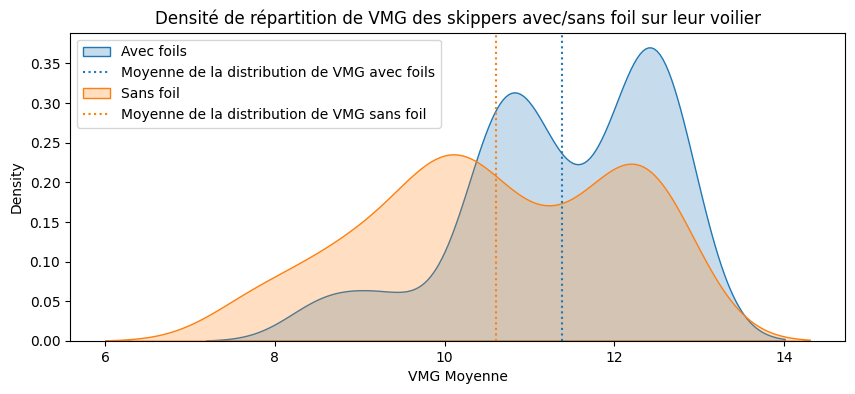

In [33]:
plt.figure(figsize=(10, 4))
sns.kdeplot(foils["VMG Moyenne"], bw=0.4, label="Avec foils", fill=True)
plt.axvline(x = foils["VMG Moyenne"].mean(), color = 'C0', label ="Moyenne de la distribution de VMG avec foils", linestyle="dotted")
sns.kdeplot(no_foil["VMG Moyenne"], bw=0.4, label="Sans foil", fill=True)
plt.axvline(x = no_foil["VMG Moyenne"].mean(), color = 'C1', label ="Moyenne de la distribution de VMG sans foil", linestyle="dotted")
plt.title("Densité de répartition de VMG des skippers avec/sans foil sur leur voilier")
plt.legend(loc="upper left")
plt.show()

In [34]:
print(f"VMG moyenne avec foils          : {foils['VMG Moyenne'].mean():.2f}")
print(f"VMG moyenne sans foil           : {no_foil['VMG Moyenne'].mean():.2f}")
print(f"Ecart-type de la VMG avec foils : {foils['VMG Moyenne'].std():.2f}")
print(f"Ecart-type de la VMG sans foil  : {no_foil['VMG Moyenne'].std():.2f}")

VMG moyenne avec foils          : 11.39
VMG moyenne sans foil           : 10.61
Ecart-type de la VMG avec foils : 1.17
Ecart-type de la VMG sans foil  : 1.51


De même que pour les classements, on remarque donc, qu'à dispertion similaire, la VMG des skippers avec foils est bien supérieure à celle des skippers sans foil !

On peut retrouver ces résultats sur la courbe de comparaison classement / VMG sur le graphe ci-dessous

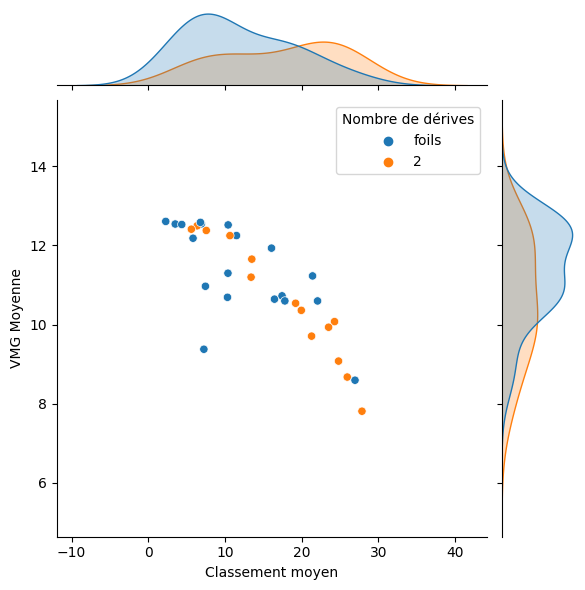

In [35]:
sns.jointplot(data=moyennes_merge_df, x="Classement moyen", y="VMG Moyenne", hue="Nombre de dérives", height=6, kind="scatter")
plt.show()

La présence de foils sur le voilier semble donc bien être un facteur favorisant un bon classement.

### 3.6. Analyses de séries temporelles

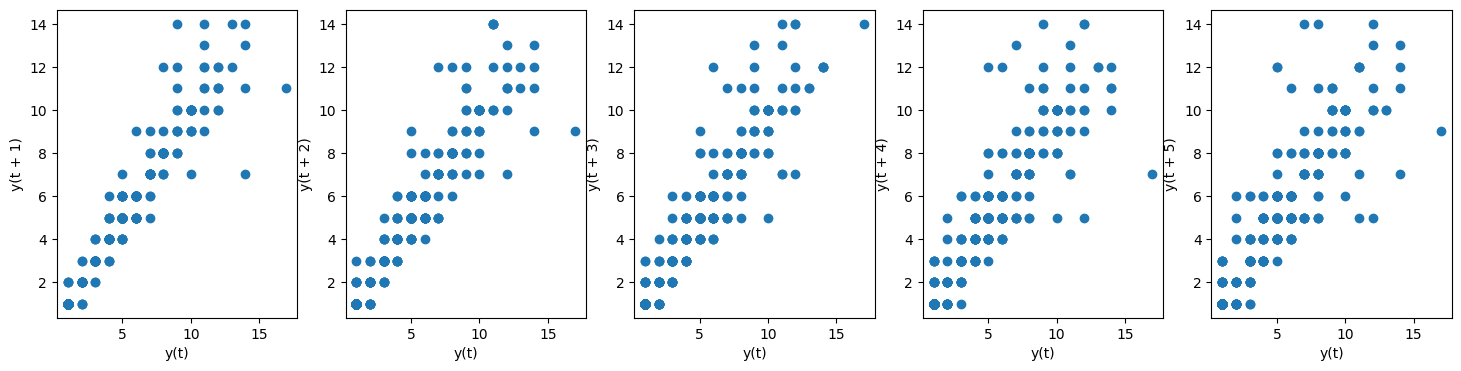

In [36]:
yan = df_running[df_running["Skipper"] == "Yannick Bestaven"]
plt.rcParams['figure.figsize'] = [18, 4]
fig, axs = plt.subplots(1, 5)
pd.plotting.lag_plot(yan["rank"], lag=1, ax=axs[0])
pd.plotting.lag_plot(yan["rank"], lag=2, ax=axs[1])
pd.plotting.lag_plot(yan["rank"], lag=3, ax=axs[2])
pd.plotting.lag_plot(yan["rank"], lag=4, ax=axs[3])
pd.plotting.lag_plot(yan["rank"], lag=5, ax=axs[4])
plt.show()

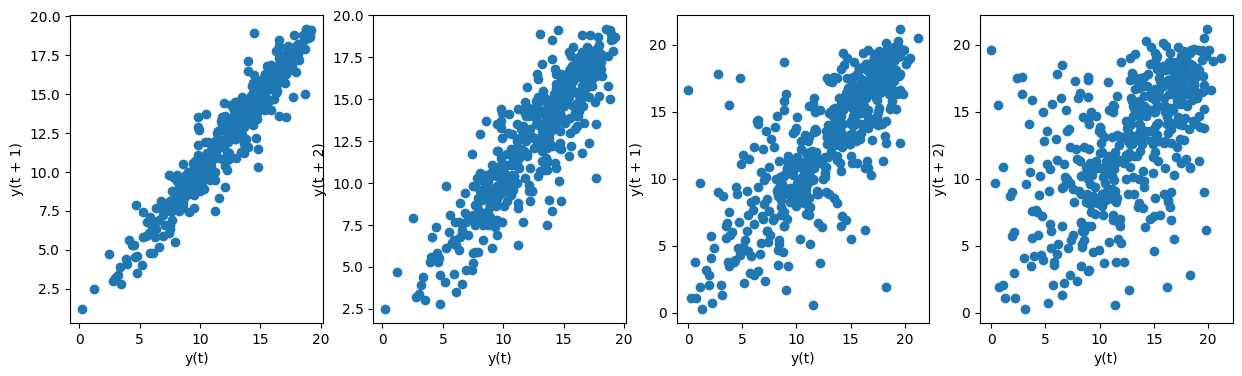

In [37]:
plt.rcParams['figure.figsize'] = [15, 4]
fig, axs = plt.subplots(1, 4)
pd.plotting.lag_plot(yan["last24h_VMG"], lag=1, ax=axs[0])
pd.plotting.lag_plot(yan["last24h_VMG"], lag=2, ax=axs[1])
pd.plotting.lag_plot(yan["lastranking_VMG"], lag=1, ax=axs[2])
pd.plotting.lag_plot(yan["lastranking_VMG"], lag=2, ax=axs[3])
plt.show()

In [38]:
df_skippers = []
for skipper in df_running["Skipper"].unique():
    df_skippers.append(df_running[df_running["Skipper"] == skipper])
for df in df_skippers:
    df.insert(2, "next_rank", "0")
    df["next_rank"] = df["rank"].shift(-1)
    df["rank-1"] = df["rank"].shift(1)
    df["rank-2"] = df["rank"].shift(2)
    df["rank-3"] = df["rank"].shift(3)
    df["rank-4"] = df["rank"].shift(4)
    df["rank-5"] = df["rank"].shift(5)
    df["next_VMG"] = df["last24h_VMG"].shift(-1)

df_timeseries = pd.concat(df_skippers)
df_timeseries = df_timeseries.sort_values(by=["datetime", "rank"], ascending=[True,True], axis=0, ignore_index=True)
df_timeseries

datetime  rank  next_rank    Voile           Skipper  \
0     2020-11-08 14:00:00   1.0        8.0   FRA 18      Louis Burton   
1     2020-11-08 14:00:00   2.0        5.0   MON 10    Boris Herrmann   
2     2020-11-08 14:00:00   3.0        1.0    FRA 8     Jérémie Beyou   
3     2020-11-08 14:00:00   4.0        4.0   FRA 59     Thomas Ruyant   
4     2020-11-08 14:00:00   5.0       13.0   FRA 53      Maxime Sorel   
...                   ...   ...        ...      ...               ...   
19222 2021-03-05 04:00:00   NaN        NaN   FRA 85   Kevin Escoffier   
19223 2021-03-05 04:00:00   NaN        NaN  FRA 109   Samantha Davies   
19224 2021-03-05 04:00:00   NaN        NaN    FRA 6  Nicolas Troussel   
19225 2021-03-05 04:00:00   NaN        NaN   FRA 27  Isabelle Joschke   
19226 2021-03-05 04:00:00   NaN        NaN    FRA 4   Sébastien Simon   

                                   Bateau   Latitude  Longitude last30m_Cap  \
0                         Bureau Vallée 2  46.407667  -1.841333         241   
1      Seaexplorer - Yacht Club De Monaco  46.405667  -1.830333         241   
2                                  Charal  46.415167  -1.833167         244   
3                               LinkedOut  46.411833  -1.828000         244   
4                         V And B Mayenne  46.409833  -1.826000         246   
...                                   ...        ...        ...         ...   
19222                                 PRB        NaN        NaN               
19223                 Initiatives - Coeur        NaN        NaN               
19224                     CORUM L'Épargne        NaN        NaN               
19225                               MACSF        NaN        NaN               
19226                        ARKEA PAPREC        NaN        NaN               

       last30m_Vitesse  ...  last24h_VMG  last24h_Distance      DTF  DTL  \
0                 17.7  ...          0.3               6.1  24293.9  0.0   
1                 11.1  ...          0.2               6.0  24294.2  0.4   
2                 15.5  ...          0.2               5.5  24294.3  0.5   
3                 13.2  ...          0.2               5.6  24294.5  0.6   
4                 10.9  ...          0.7               5.8  24294.5  0.6   
...                ...  ...          ...               ...      ...  ...   
19222              NaN  ...          NaN               NaN      NaN  NaN   
19223              NaN  ...          NaN               NaN      NaN  NaN   
19224              NaN  ...          NaN               NaN      NaN  NaN   
19225              NaN  ...          NaN               NaN      NaN  NaN   
19226              NaN  ...          NaN               NaN      NaN  NaN   

       rank-1  rank-2 rank-3  rank-4  rank-5  next_VMG  
0         NaN     NaN    NaN     NaN     NaN       1.3  
1         NaN     NaN    NaN     NaN     NaN       1.3  
2         NaN     NaN    NaN     NaN     NaN       1.4  
3         NaN     NaN    NaN     NaN     NaN       1.3  
4         NaN     NaN    NaN     NaN     NaN       3.1  
...       ...     ...    ...     ...     ...       ...  
19222     NaN     NaN    NaN     NaN     NaN       NaN  
19223     NaN     NaN    NaN     NaN     NaN       NaN  
19224     NaN     NaN    NaN     NaN     NaN       NaN  
19225     NaN     NaN    NaN     NaN     NaN       NaN  
19226     NaN     NaN    NaN     NaN     NaN       NaN  

[19227 rows x 28 columns]

In [39]:
unique_skippers = df_running["Skipper"].unique().tolist()
mapping_skip = {}
for i, skipper in enumerate(unique_skippers):
    mapping_skip[skipper] = i
mapping_skip

{'Louis Burton': 0,
 'Boris Herrmann': 1,
 'Jérémie Beyou': 2,
 'Thomas Ruyant': 3,
 'Maxime Sorel': 4,
 'Fabrice Amedeo': 5,
 'Jean Le Cam': 6,
 'Alex Thomson': 7,
 'Sébastien Destremau': 8,
 'Pip Hare': 9,
 'Kevin Escoffier': 10,
 'Stéphane Le Diraison': 11,
 'Romain Attanasio': 12,
 'Damien Seguin': 13,
 'Clément Giraud': 14,
 'Samantha Davies': 15,
 'Yannick Bestaven': 16,
 'Giancarlo Pedote': 17,
 'Kojiro Shiraishi': 18,
 'Nicolas Troussel': 19,
 'Manuel Cousin': 20,
 'Clarisse Cremer': 21,
 'Alan Roura': 22,
 'Didac Costa': 23,
 'Benjamin Dutreux': 24,
 'Armel Tripon': 25,
 'Alexia Barrier': 26,
 'Isabelle Joschke': 27,
 'Sébastien Simon': 28,
 'Miranda Merron': 29,
 'Ari Huusela': 30,
 'Charlie Dalin': 31,
 'Arnaud Boissieres': 32}

Test modèle basé sur classement actuel, VMG sur les dernières 24h et présence/absence de foils

In [40]:
df_model = pd.merge(left=df_timeseries, right=df_boats, left_on="Skipper", right_on="skipper_name", how="left")
df_model = df_model[["Skipper", "rank-5", "rank-4", "rank-3", "rank-2", "rank-1", "rank", "last24h_VMG", "Nombre de dérives", "next_rank", "next_VMG"]]
df_model  = df_model .rename(columns={"Nombre de dérives": "dérives", "last24h_VMG": "VMG"})
df_model["Skipper"] = df_model["Skipper"].map(mapping_skip)
# fois -> 1, dérives -> 2
df_model = df_model.replace("foils", "1")
df_model = df_model.replace("2 asymétriques", "2")
df_model["dérives"] = pd.to_numeric(df_model["dérives"], errors="coerce").astype(float)
df_model = df_model[df_model["rank"].notna()]
df_model = df_model[df_model["next_rank"].notna()]
df_model["baseline_rank_pred"] = df_model["rank"]
df_model["baseline_VMG_pred"] = df_model["VMG"]
df_model = df_model.dropna().reset_index(drop=True)
df_model

Skipper  rank-5  rank-4  rank-3  rank-2  rank-1  rank  VMG  dérives  \
0            6     7.0    19.0    18.0     9.0     2.0   1.0  8.6      2.0   
1            4     5.0    13.0    16.0    16.0     1.0   2.0  8.8      2.0   
2           13    14.0    15.0    17.0    17.0     3.0   3.0  8.7      2.0   
3           11    12.0    21.0    19.0    18.0     9.0   4.0  8.2      1.0   
4           12    13.0    20.0    21.0    22.0    10.0   5.0  8.3      2.0   
...        ...     ...     ...     ...     ...     ...   ...  ...      ...   
15069       30    25.0    25.0    25.0    25.0    25.0  25.0  8.7      2.0   
15070       30    25.0    25.0    25.0    25.0    25.0  25.0  7.9      2.0   
15071       30    25.0    25.0    25.0    25.0    25.0  25.0  7.1      2.0   
15072       30    25.0    25.0    25.0    25.0    25.0  25.0  6.9      2.0   
15073       30    25.0    25.0    25.0    25.0    25.0  25.0  6.9      2.0   

       next_rank  next_VMG  baseline_rank_pred  baseline_VMG_pred  
0            3.0       9.5                 1.0                8.6  
1            2.0       9.6                 2.0                8.8  
2            1.0       9.5                 3.0                8.7  
3            7.0       8.9                 4.0                8.2  
4            5.0       9.2                 5.0                8.3  
...          ...       ...                 ...                ...  
15069       25.0       7.9                25.0                8.7  
15070       25.0       7.1                25.0                7.9  
15071       25.0       6.9                25.0                7.1  
15072       25.0       6.9                25.0                6.9  
15073       25.0       6.7                25.0                6.9  

[15074 rows x 13 columns]

#### 3.6.1. Prédiction classement

In [41]:
X = df_model[["Skipper", "rank-5", "rank-4", "rank-3", "rank-2", "rank-1", "rank", "VMG", "dérives"]]
y = df_model[["next_rank"]]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, y_train = X[:10000], y[:10000]
X_test, y_test = X[10000:], y[10000:]

Baseline score

In [42]:
mse(df_model["next_rank"], df_model["baseline_rank_pred"])

0.4899827517579939

In [43]:
def evaluate_rank_model(model, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    y_pred = np.round_(mod.predict(X_test))
    return mse(y_test, y_pred)

In [44]:
models = [LinearRegression(), RidgeCV(), LassoCV(), ElasticNetCV(), DecisionTreeRegressor(),
          GradientBoostingRegressor(), RandomForestRegressor(), AdaBoostRegressor()]
scores = []
for mod in models:
    score = evaluate_rank_model(mod, X_train, X_test, y_train, y_test)
    print(f"{mod.__class__.__name__} : {score}")
    scores.append(score)

LinearRegression : 0.06326369728025226
RidgeCV : 0.06326369728025226
LassoCV : 0.06326369728025226
ElasticNetCV : 0.06326369728025226
DecisionTreeRegressor : 0.5402049664958612
GradientBoostingRegressor : 0.07094994087504927
RandomForestRegressor : 0.2081198265668112
AdaBoostRegressor : 1.8413480488766258


In [45]:
gradboost = GradientBoostingRegressor()
gradboost.fit(X_train, y_train)
df_model["predicted_rank"] = np.round_(gradboost.predict(X))
df_model

Skipper  rank-5  rank-4  rank-3  rank-2  rank-1  rank  VMG  dérives  \
0            6     7.0    19.0    18.0     9.0     2.0   1.0  8.6      2.0   
1            4     5.0    13.0    16.0    16.0     1.0   2.0  8.8      2.0   
2           13    14.0    15.0    17.0    17.0     3.0   3.0  8.7      2.0   
3           11    12.0    21.0    19.0    18.0     9.0   4.0  8.2      1.0   
4           12    13.0    20.0    21.0    22.0    10.0   5.0  8.3      2.0   
...        ...     ...     ...     ...     ...     ...   ...  ...      ...   
15069       30    25.0    25.0    25.0    25.0    25.0  25.0  8.7      2.0   
15070       30    25.0    25.0    25.0    25.0    25.0  25.0  7.9      2.0   
15071       30    25.0    25.0    25.0    25.0    25.0  25.0  7.1      2.0   
15072       30    25.0    25.0    25.0    25.0    25.0  25.0  6.9      2.0   
15073       30    25.0    25.0    25.0    25.0    25.0  25.0  6.9      2.0   

       next_rank  next_VMG  baseline_rank_pred  baseline_VMG_pred  \
0            3.0       9.5                 1.0                8.6   
1            2.0       9.6                 2.0                8.8   
2            1.0       9.5                 3.0                8.7   
3            7.0       8.9                 4.0                8.2   
4            5.0       9.2                 5.0                8.3   
...          ...       ...                 ...                ...   
15069       25.0       7.9                25.0                8.7   
15070       25.0       7.1                25.0                7.9   
15071       25.0       6.9                25.0                7.1   
15072       25.0       6.9                25.0                6.9   
15073       25.0       6.7                25.0                6.9   

       predicted_rank  
0                 3.0  
1                 3.0  
2                 4.0  
3                 6.0  
4                 6.0  
...               ...  
15069            25.0  
15070            25.0  
15071            25.0  
15072            25.0  
15073            25.0  

[15074 rows x 14 columns]

In [46]:
# forest = RandomForestRegressor()
# forest.fit(X_train, y_train)
# df_model["predicted_rank"] = np.round_(forest.predict(X))
# df_model

In [47]:
# linreg = LinearRegression()
# linreg.fit(X_train, y_train)
# df_model["predicted_rank"] = np.round_(linreg.predict(X))
# df_model

In [48]:
mse(df_model["next_rank"], df_model["predicted_rank"])

0.3696430940692583

Bien mieux que baseline

#### 3.6.2. Prédiction vitesse

In [49]:
X = df_model[["Skipper", "rank-5", "rank-4", "rank-3", "rank-2", "rank-1", "rank", "VMG", "dérives"]]
y = df_model[["next_VMG"]]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, y_train = X[:10000], y[:10000]
X_test, y_test = X[10000:], y[10000:]

In [50]:
mse(df_model["next_VMG"], df_model["baseline_VMG_pred"])

0.685530051744726

In [51]:
def evaluate_VMG_model(model, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    return mse(y_test, y_pred)

In [52]:
models = [LinearRegression(), RidgeCV(), LassoCV(), ElasticNetCV(), DecisionTreeRegressor(),
          GradientBoostingRegressor(), RandomForestRegressor(), AdaBoostRegressor()]
scores = []
for mod in models:
    score = evaluate_VMG_model(mod, X_train, X_test, y_train, y_test)
    print(f"{mod.__class__.__name__} : {score}")
    scores.append(score)

LinearRegression : 0.6133202460607347
RidgeCV : 0.6133218909374608
LassoCV : 0.6139283928757139
ElasticNetCV : 0.6139714973552733
DecisionTreeRegressor : 1.342747051897227
GradientBoostingRegressor : 0.6198393583357504
RandomForestRegressor : 0.7622411142074323
AdaBoostRegressor : 0.788359139851463


In [53]:
# ridge = RidgeCV()
# ridge.fit(X_train, y_train)
# df_model["predicted_VMG"] = ridge.predict(X)
# df_model

In [54]:
gradboost_vmg = GradientBoostingRegressor()
gradboost_vmg.fit(X_train, y_train)
df_model["predicted_VMG"] = np.round_(gradboost_vmg.predict(X))
df_model

Skipper  rank-5  rank-4  rank-3  rank-2  rank-1  rank  VMG  dérives  \
0            6     7.0    19.0    18.0     9.0     2.0   1.0  8.6      2.0   
1            4     5.0    13.0    16.0    16.0     1.0   2.0  8.8      2.0   
2           13    14.0    15.0    17.0    17.0     3.0   3.0  8.7      2.0   
3           11    12.0    21.0    19.0    18.0     9.0   4.0  8.2      1.0   
4           12    13.0    20.0    21.0    22.0    10.0   5.0  8.3      2.0   
...        ...     ...     ...     ...     ...     ...   ...  ...      ...   
15069       30    25.0    25.0    25.0    25.0    25.0  25.0  8.7      2.0   
15070       30    25.0    25.0    25.0    25.0    25.0  25.0  7.9      2.0   
15071       30    25.0    25.0    25.0    25.0    25.0  25.0  7.1      2.0   
15072       30    25.0    25.0    25.0    25.0    25.0  25.0  6.9      2.0   
15073       30    25.0    25.0    25.0    25.0    25.0  25.0  6.9      2.0   

       next_rank  next_VMG  baseline_rank_pred  baseline_VMG_pred  \
0            3.0       9.5                 1.0                8.6   
1            2.0       9.6                 2.0                8.8   
2            1.0       9.5                 3.0                8.7   
3            7.0       8.9                 4.0                8.2   
4            5.0       9.2                 5.0                8.3   
...          ...       ...                 ...                ...   
15069       25.0       7.9                25.0                8.7   
15070       25.0       7.1                25.0                7.9   
15071       25.0       6.9                25.0                7.1   
15072       25.0       6.9                25.0                6.9   
15073       25.0       6.7                25.0                6.9   

       predicted_rank  predicted_VMG  
0                 3.0            9.0  
1                 3.0            9.0  
2                 4.0            9.0  
3                 6.0            8.0  
4                 6.0            8.0  
...               ...            ...  
15069            25.0            9.0  
15070            25.0            8.0  
15071            25.0            7.0  
15072            25.0            7.0  
15073            25.0            7.0  

[15074 rows x 15 columns]

In [55]:
# forest_vmg = RandomForestRegressor()
# forest_vmg.fit(X_train, y_train)
# df_model["predicted_VMG"] = np.round_(forest_vmg.predict(X))
# df_model

In [56]:
# adaboost = AdaBoostRegressor()
# adaboost.fit(X_train, y_train)
# df_model["predicted_VMG"] = np.round_(adaboost.predict(X))
# df_model

In [57]:
mse(df_model["next_VMG"], df_model["predicted_VMG"])

0.746468754146212

[//]: <> (Récap : gradientboosting pour prédire le classement, ridge pour prédire la VMG
    -> je test ça en itérant sur les points à partir du milieu du classement)
    
Je prends RandomForest dans les 2 cas pour tester, à voir comment justifier ça après

#### 3.6.3. Prédictions sur plusieurs jours

In [58]:
df_predict = df_timeseries[df_timeseries["datetime"].isin(df_timeseries["datetime"].unique()[:465])]
df_predict = pd.merge(left=df_predict, right=df_boats, left_on="Skipper", right_on="skipper_name", how="left")
df_predict["Skipper"] = df_predict["Skipper"].map(mapping_skip)
# df_predict = df_predict[["Skipper", "rank-5", "rank-4", "rank-3", "rank-2", "rank-1", "rank", "last24h_VMG", "Latitude", "Longitude", "Nombre de dérives"]]
df_predict = df_predict[["Skipper", "rank-5", "rank-4", "rank-3", "rank-2", "rank-1", "rank", "last24h_VMG", "Nombre de dérives"]]
df_predict = df_predict.replace("foils", "1")
df_predict = df_predict.replace("2 asymétriques", "2")
df_predict = df_predict.rename(columns={"Nombre de dérives": "dérives", "last24h_VMG": "VMG"})
df_predict["dérives"] = pd.to_numeric(df_predict["dérives"], errors="coerce").astype(float)
df_predict = df_predict.dropna().reset_index(drop=True)
df_predict

Skipper  rank-5  rank-4  rank-3  rank-2  rank-1  rank   VMG  dérives
0            6     7.0    19.0    18.0     9.0     2.0   1.0   8.6      2.0
1            4     5.0    13.0    16.0    16.0     1.0   2.0   8.8      2.0
2           13    14.0    15.0    17.0    17.0     3.0   3.0   8.7      2.0
3           11    12.0    21.0    19.0    18.0     9.0   4.0   8.2      1.0
4           12    13.0    20.0    21.0    22.0    10.0   5.0   8.3      2.0
...        ...     ...     ...     ...     ...     ...   ...   ...      ...
13108       20    21.0    21.0    21.0    21.0    21.0  21.0   8.6      2.0
13109       14    23.0    22.0    22.0    22.0    22.0  22.0  13.6      2.0
13110       29    22.0    23.0    23.0    23.0    23.0  23.0  12.1      2.0
13111       26    24.0    24.0    24.0    24.0    24.0  24.0  10.6      2.0
13112       30    25.0    25.0    25.0    25.0    25.0  25.0  14.1      2.0

[13113 rows x 9 columns]

On part de 465 points de classement, on va prédire jusqu'à 701 pour comparer avec le résultat final <br>
On commence par prédire 10 points dans le future pour voir

In [59]:
def predict_next(df_predict, model_rank, model_vmg):
    df_skippers = []
    for skipper in df_predict["Skipper"].unique():
        df_skippers.append(df_predict[df_predict["Skipper"] == skipper])

    for df in df_skippers:
        latest = df.iloc[-1][["Skipper", "rank-5", "rank-4", "rank-3", "rank-2", "rank-1", "rank", "VMG", "dérives"]]
        if np.isnan(df['rank'].iloc[-1]):
            continue
        else:
            next_rank = np.round_(model_rank.predict(latest.to_numpy().reshape(1,-1)))[0]
            next_vmg = model_vmg.predict(latest.to_numpy().reshape(1,-1))[0]
            tmp = pd.DataFrame([[df.iloc[0]["Skipper"], latest["rank-4"], latest["rank-3"], latest["rank-2"],
                                 latest["rank-1"], latest["rank"], next_rank, next_vmg, df.iloc[0]["dérives"]]],
                               columns=["Skipper", "rank-5", "rank-4", "rank-3", "rank-2", "rank-1",
                                        "rank", "VMG", "dérives"])
            df_predict = pd.concat([df_predict, tmp], ignore_index=True)
    
    return df_predict

In [60]:
#predict_next(df_predict, forest, adaboost)

In [61]:
t0 = time.time()
for i in range(100):
    df_predict = predict_next(df_predict, gradboost, gradboost_vmg)
t1 = time.time()
print(t1 - t0)
display(df_predict)

4.933766603469849


Skipper  rank-5  rank-4  rank-3  rank-2  rank-1  rank        VMG  \
0          6.0     7.0    19.0    18.0     9.0     2.0   1.0   8.600000   
1          4.0     5.0    13.0    16.0    16.0     1.0   2.0   8.800000   
2         13.0    14.0    15.0    17.0    17.0     3.0   3.0   8.700000   
3         11.0    12.0    21.0    19.0    18.0     9.0   4.0   8.200000   
4         12.0    13.0    20.0    21.0    22.0    10.0   5.0   8.300000   
...        ...     ...     ...     ...     ...     ...   ...        ...   
16408     26.0    24.0    24.0    24.0    24.0    24.0  24.0  10.533852   
16409      8.0    28.0    28.0    28.0    28.0    28.0  28.0  -5.253149   
16410      5.0    26.0    26.0    26.0    26.0    26.0  26.0   2.914497   
16411     31.0     2.0     2.0     2.0     2.0     2.0   2.0  14.340256   
16412     32.0    15.0    15.0    15.0    15.0    15.0  15.0  11.846673   

       dérives  
0          2.0  
1          2.0  
2          2.0  
3          1.0  
4          2.0  
...        ...  
16408      2.0  
16409      2.0  
16410      1.0  
16411      1.0  
16412      1.0  

[16413 rows x 9 columns]

In [62]:
df_running["Skipper"].unique()

array(['Louis Burton', 'Boris Herrmann', 'Jérémie Beyou', 'Thomas Ruyant',
       'Maxime Sorel', 'Fabrice Amedeo', 'Jean Le Cam', 'Alex Thomson',
       'Sébastien Destremau', 'Pip Hare', 'Kevin Escoffier',
       'Stéphane Le Diraison', 'Romain Attanasio', 'Damien Seguin',
       'Clément Giraud', 'Samantha Davies', 'Yannick Bestaven',
       'Giancarlo Pedote', 'Kojiro Shiraishi', 'Nicolas Troussel',
       'Manuel Cousin', 'Clarisse Cremer', 'Alan Roura', 'Didac Costa',
       'Benjamin Dutreux', 'Armel Tripon', 'Alexia Barrier',
       'Isabelle Joschke', 'Sébastien Simon', 'Miranda Merron',
       'Ari Huusela', 'Charlie Dalin', 'Arnaud Boissieres'], dtype=object)

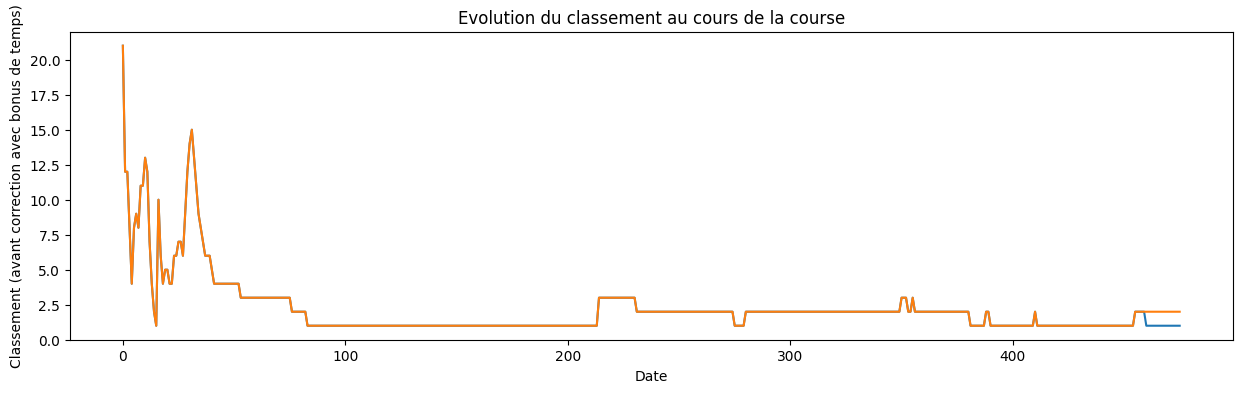

In [63]:
plt.plot(np.arange(476),df_running[df_running["Skipper"] == "Charlie Dalin"]["rank"][6:])
plt.plot(np.arange(476),df_predict[df_predict["Skipper"] == mapping_skip["Charlie Dalin"]]["rank"][:476])
plt.title('Evolution du classement au cours de la course')
plt.xlabel('Date')
plt.ylabel('Classement (avant correction avec bonus de temps)')
plt.show()

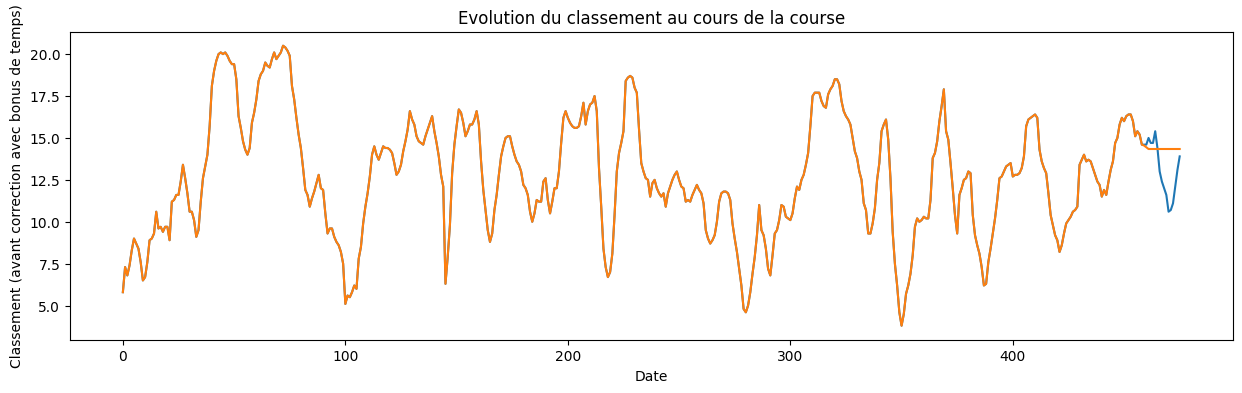

In [64]:
plt.plot(np.arange(476),df_running[df_running["Skipper"] == "Charlie Dalin"]["last24h_VMG"][6:])
plt.plot(np.arange(476),df_predict[df_predict["Skipper"] == mapping_skip["Charlie Dalin"]]["VMG"][:476])
plt.title('Evolution du classement au cours de la course')
plt.xlabel('Date')
plt.ylabel('Classement (avant correction avec bonus de temps)')
plt.show()

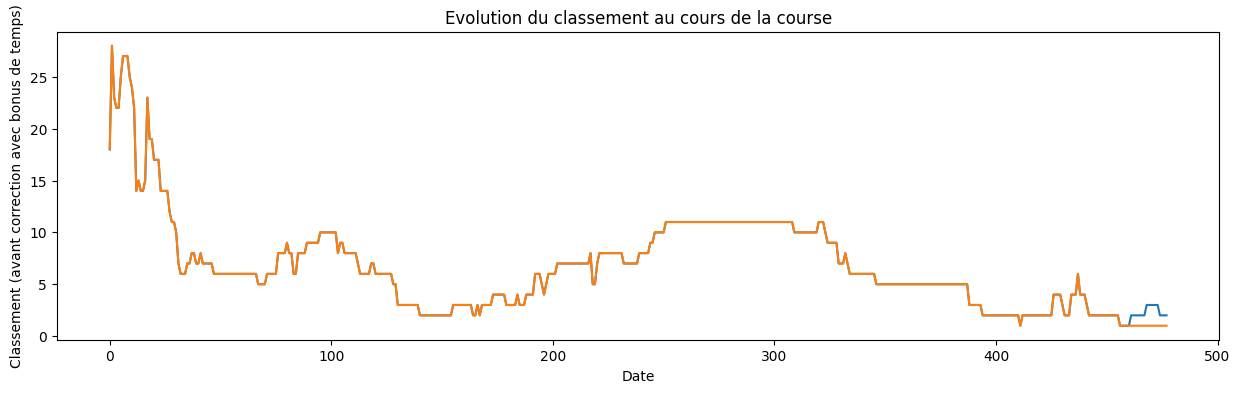

In [65]:
plt.plot(np.arange(478),df_running[df_running["Skipper"] == "Louis Burton"]["rank"][5:])
plt.plot(np.arange(478),df_predict[df_predict["Skipper"] == mapping_skip["Louis Burton"]]["rank"][:478])
plt.title('Evolution du classement au cours de la course')
plt.xlabel('Date')
plt.ylabel('Classement (avant correction avec bonus de temps)')
plt.show()

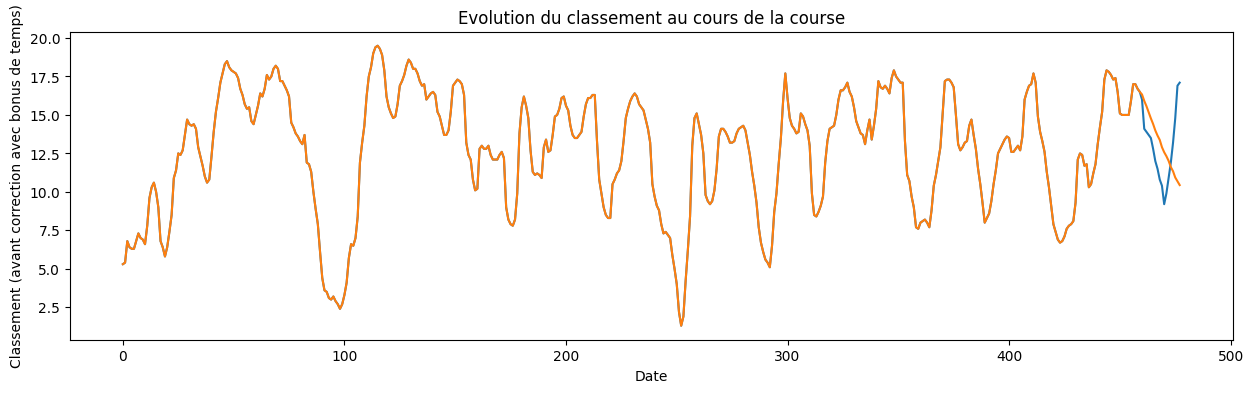

In [66]:
plt.plot(np.arange(478),df_running[df_running["Skipper"] == "Louis Burton"]["last24h_VMG"][5:])
plt.plot(np.arange(478),df_predict[df_predict["Skipper"] == mapping_skip["Louis Burton"]]["VMG"][:478])
plt.title('Evolution du classement au cours de la course')
plt.xlabel('Date')
plt.ylabel('Classement (avant correction avec bonus de temps)')
plt.show()

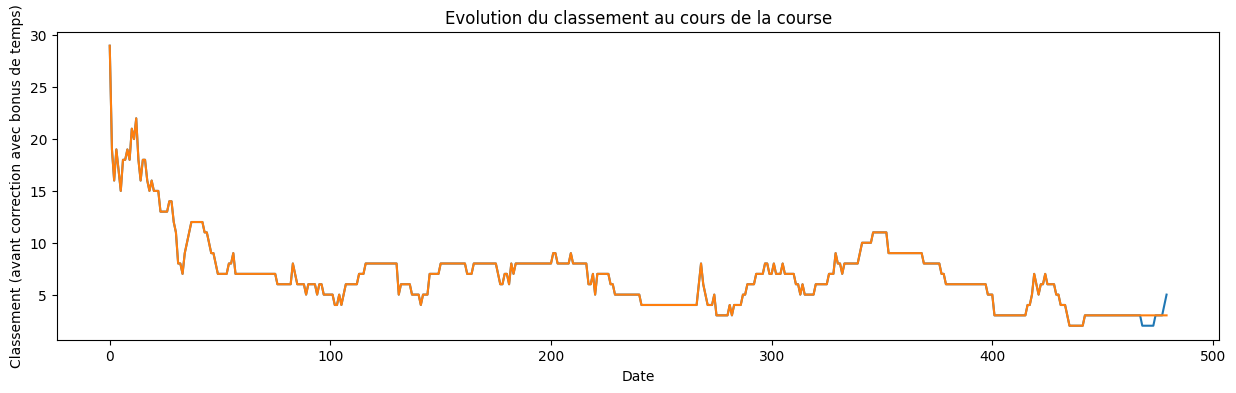

In [67]:
plt.plot(np.arange(480),df_running[df_running["Skipper"] == "Boris Herrmann"]["rank"][5:])
plt.plot(np.arange(480),df_predict[df_predict["Skipper"] == mapping_skip["Boris Herrmann"]]["rank"][:480])
plt.title('Evolution du classement au cours de la course')
plt.xlabel('Date')
plt.ylabel('Classement (avant correction avec bonus de temps)')
plt.show()

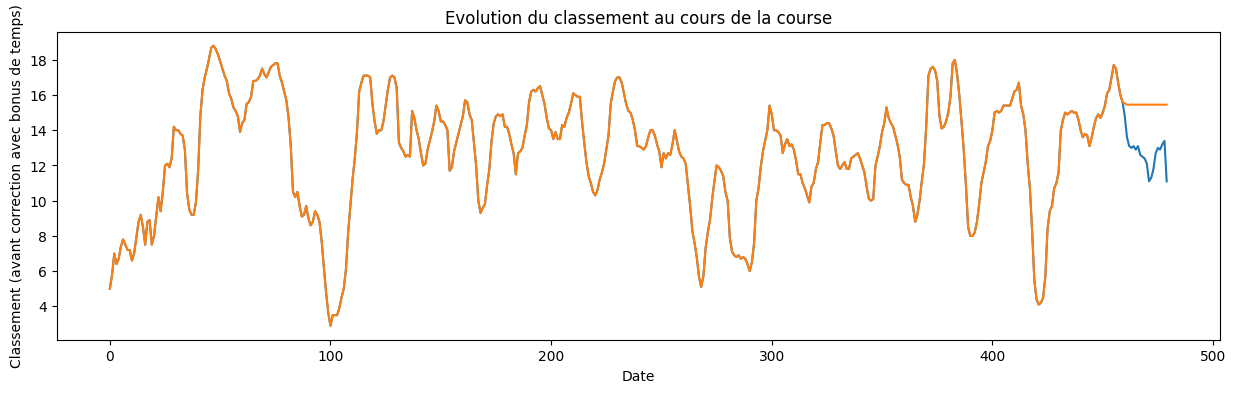

In [68]:
plt.plot(np.arange(480),df_running[df_running["Skipper"] == "Boris Herrmann"]["last24h_VMG"][5:])
plt.plot(np.arange(480),df_predict[df_predict["Skipper"] == mapping_skip["Boris Herrmann"]]["VMG"][:480])
plt.title('Evolution du classement au cours de la course')
plt.xlabel('Date')
plt.ylabel('Classement (avant correction avec bonus de temps)')
plt.show()

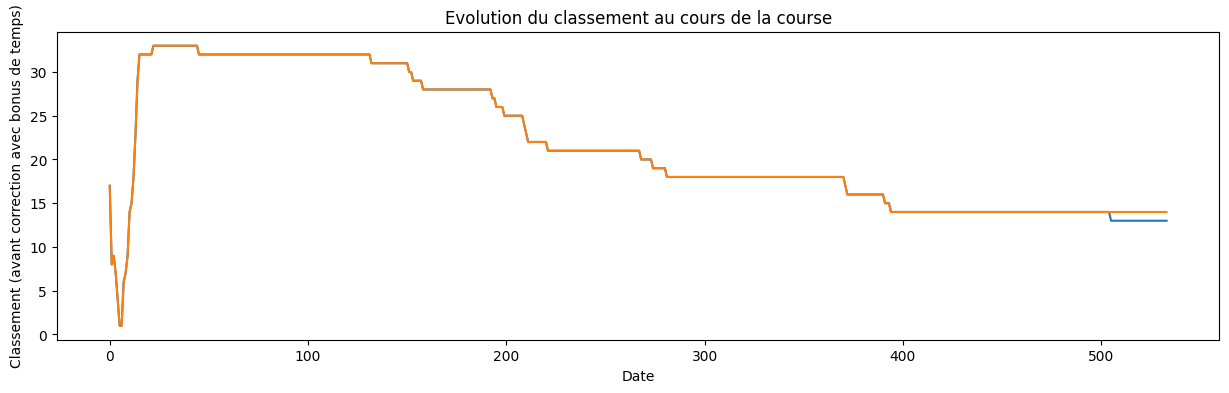

In [69]:
plt.plot(np.arange(534),df_running[df_running["Skipper"] == "Jérémie Beyou"]["rank"][5:])
plt.plot(np.arange(534),df_predict[df_predict["Skipper"] == mapping_skip["Jérémie Beyou"]]["rank"][:534])
plt.title('Evolution du classement au cours de la course')
plt.xlabel('Date')
plt.ylabel('Classement (avant correction avec bonus de temps)')
plt.show()

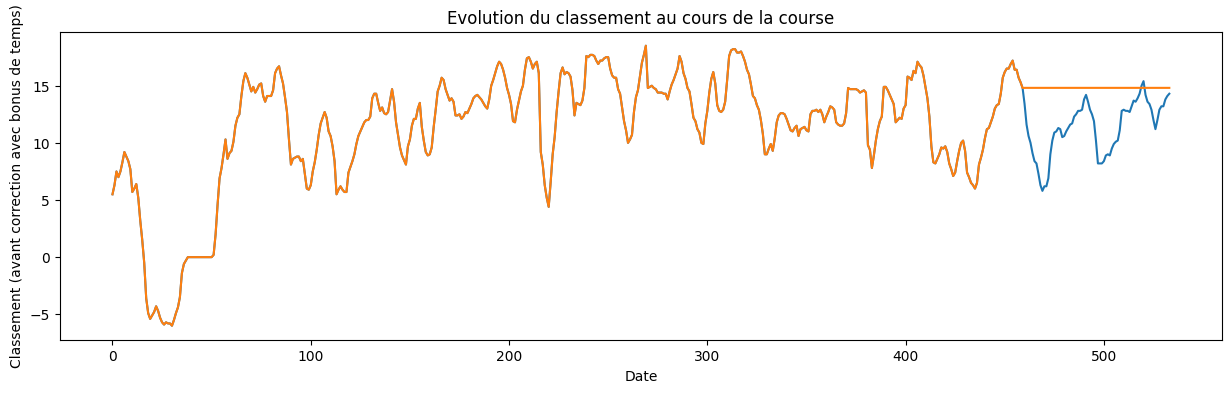

In [70]:
plt.plot(np.arange(534),df_running[df_running["Skipper"] == "Jérémie Beyou"]["last24h_VMG"][5:])
plt.plot(np.arange(534),df_predict[df_predict["Skipper"] == mapping_skip["Jérémie Beyou"]]["VMG"][:534])
plt.title('Evolution du classement au cours de la course')
plt.xlabel('Date')
plt.ylabel('Classement (avant correction avec bonus de temps)')
plt.show()

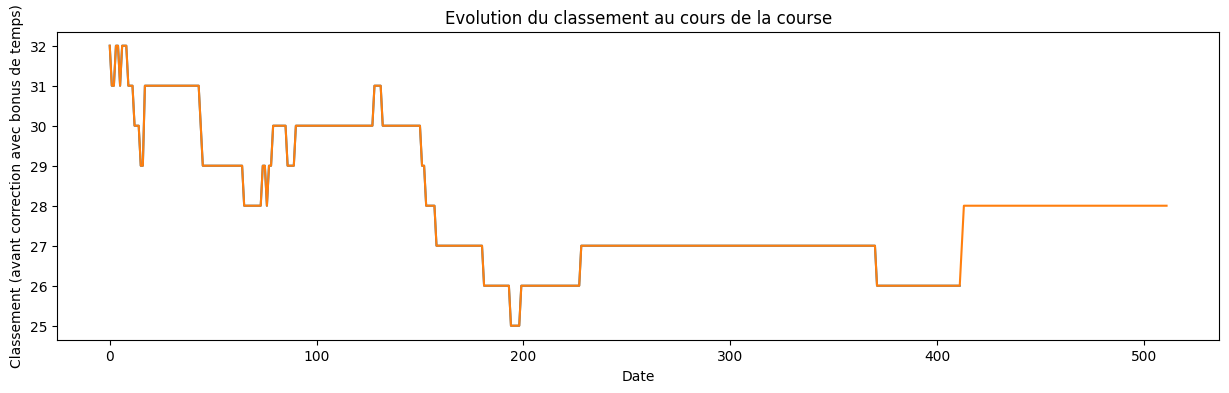

In [71]:
plt.plot(np.arange(512),df_running[df_running["Skipper"] == "Sébastien Destremau"]["rank"][5:517])
plt.plot(np.arange(512),df_predict[df_predict["Skipper"] == mapping_skip["Sébastien Destremau"]]["rank"])
plt.title('Evolution du classement au cours de la course')
plt.xlabel('Date')
plt.ylabel('Classement (avant correction avec bonus de temps)')
plt.show()

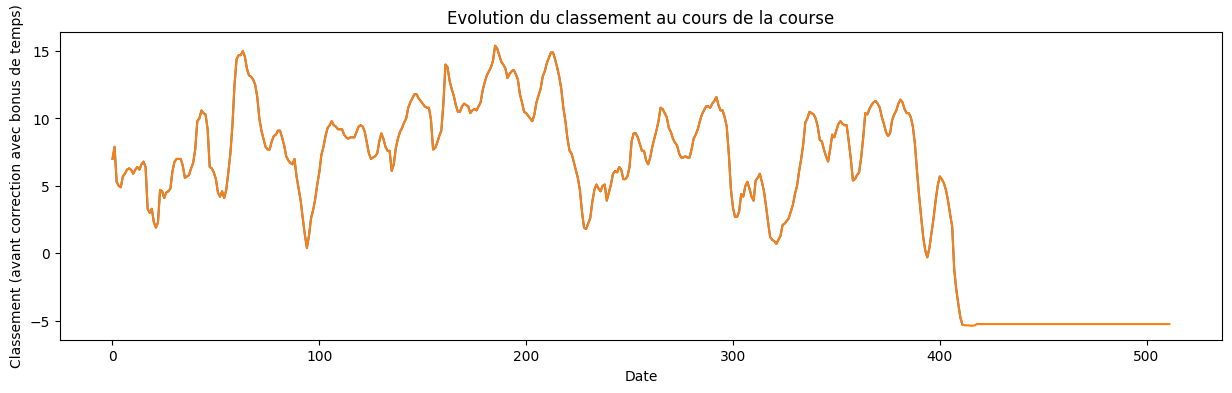

In [72]:
plt.plot(np.arange(512),df_running[df_running["Skipper"] == "Sébastien Destremau"]["last24h_VMG"][5:517])
plt.plot(np.arange(512),df_predict[df_predict["Skipper"] == mapping_skip["Sébastien Destremau"]]["VMG"])
plt.title('Evolution du classement au cours de la course')
plt.xlabel('Date')
plt.ylabel('Classement (avant correction avec bonus de temps)')
plt.show()

In [73]:
df_timeseries

datetime  rank  next_rank    Voile           Skipper  \
0     2020-11-08 14:00:00   1.0        8.0   FRA 18      Louis Burton   
1     2020-11-08 14:00:00   2.0        5.0   MON 10    Boris Herrmann   
2     2020-11-08 14:00:00   3.0        1.0    FRA 8     Jérémie Beyou   
3     2020-11-08 14:00:00   4.0        4.0   FRA 59     Thomas Ruyant   
4     2020-11-08 14:00:00   5.0       13.0   FRA 53      Maxime Sorel   
...                   ...   ...        ...      ...               ...   
19222 2021-03-05 04:00:00   NaN        NaN   FRA 85   Kevin Escoffier   
19223 2021-03-05 04:00:00   NaN        NaN  FRA 109   Samantha Davies   
19224 2021-03-05 04:00:00   NaN        NaN    FRA 6  Nicolas Troussel   
19225 2021-03-05 04:00:00   NaN        NaN   FRA 27  Isabelle Joschke   
19226 2021-03-05 04:00:00   NaN        NaN    FRA 4   Sébastien Simon   

                                   Bateau   Latitude  Longitude last30m_Cap  \
0                         Bureau Vallée 2  46.407667  -1.841333         241   
1      Seaexplorer - Yacht Club De Monaco  46.405667  -1.830333         241   
2                                  Charal  46.415167  -1.833167         244   
3                               LinkedOut  46.411833  -1.828000         244   
4                         V And B Mayenne  46.409833  -1.826000         246   
...                                   ...        ...        ...         ...   
19222                                 PRB        NaN        NaN               
19223                 Initiatives - Coeur        NaN        NaN               
19224                     CORUM L'Épargne        NaN        NaN               
19225                               MACSF        NaN        NaN               
19226                        ARKEA PAPREC        NaN        NaN               

       last30m_Vitesse  ...  last24h_VMG  last24h_Distance      DTF  DTL  \
0                 17.7  ...          0.3               6.1  24293.9  0.0   
1                 11.1  ...          0.2               6.0  24294.2  0.4   
2                 15.5  ...          0.2               5.5  24294.3  0.5   
3                 13.2  ...          0.2               5.6  24294.5  0.6   
4                 10.9  ...          0.7               5.8  24294.5  0.6   
...                ...  ...          ...               ...      ...  ...   
19222              NaN  ...          NaN               NaN      NaN  NaN   
19223              NaN  ...          NaN               NaN      NaN  NaN   
19224              NaN  ...          NaN               NaN      NaN  NaN   
19225              NaN  ...          NaN               NaN      NaN  NaN   
19226              NaN  ...          NaN               NaN      NaN  NaN   

       rank-1  rank-2 rank-3  rank-4  rank-5  next_VMG  
0         NaN     NaN    NaN     NaN     NaN       1.3  
1         NaN     NaN    NaN     NaN     NaN       1.3  
2         NaN     NaN    NaN     NaN     NaN       1.4  
3         NaN     NaN    NaN     NaN     NaN       1.3  
4         NaN     NaN    NaN     NaN     NaN       3.1  
...       ...     ...    ...     ...     ...       ...  
19222     NaN     NaN    NaN     NaN     NaN       NaN  
19223     NaN     NaN    NaN     NaN     NaN       NaN  
19224     NaN     NaN    NaN     NaN     NaN       NaN  
19225     NaN     NaN    NaN     NaN     NaN       NaN  
19226     NaN     NaN    NaN     NaN     NaN       NaN  

[19227 rows x 28 columns]

In [74]:
df_model = pd.merge(left=df_timeseries, right=df_boats, left_on="Skipper", right_on="skipper_name", how="left")
df_model = df_model[["Skipper", "rank-3", "rank-2", "rank-1", "rank", "last24h_VMG", "Nombre de dérives", "next_rank", "next_VMG"]]
df_model  = df_model .rename(columns={"Nombre de dérives": "dérives", "last24h_VMG": "VMG"})
df_model = df_model.replace("2 asymétriques", "2")
df_model = df_model[df_model["rank"].notna()]
df_model = df_model[df_model["next_rank"].notna()]
df_model["baseline_rank_pred"] = df_model["rank"]
df_model["baseline_VMG_pred"] = df_model["VMG"]
df_model = df_model.dropna().reset_index(drop=True)
df_model

Skipper  rank-3  rank-2  rank-1  rank  VMG dérives  next_rank  \
0         Jérémie Beyou     3.0     1.0     1.0   1.0  5.4   foils        4.0   
1      Nicolas Troussel    20.0     6.0     6.0   2.0  5.4   foils        5.0   
2          Armel Tripon    26.0    10.0     7.0   3.0  5.3   foils        6.0   
3         Thomas Ruyant     4.0     4.0     3.0   4.0  5.2   foils       18.0   
4          Alex Thomson     8.0     3.0     4.0   6.0  4.9   foils       19.0   
...                 ...     ...     ...     ...   ...  ...     ...        ...   
15135       Ari Huusela    25.0    25.0    25.0  25.0  8.7       2       25.0   
15136       Ari Huusela    25.0    25.0    25.0  25.0  7.9       2       25.0   
15137       Ari Huusela    25.0    25.0    25.0  25.0  7.1       2       25.0   
15138       Ari Huusela    25.0    25.0    25.0  25.0  6.9       2       25.0   
15139       Ari Huusela    25.0    25.0    25.0  25.0  6.9       2       25.0   

       next_VMG  baseline_rank_pred  baseline_VMG_pred  
0           5.4                 1.0                5.4  
1           5.4                 2.0                5.4  
2           5.4                 3.0                5.3  
3           4.9                 4.0                5.2  
4           7.9                 6.0                4.9  
...         ...                 ...                ...  
15135       7.9                25.0                8.7  
15136       7.1                25.0                7.9  
15137       6.9                25.0                7.1  
15138       6.9                25.0                6.9  
15139       6.7                25.0                6.9  

[15140 rows x 11 columns]

In [75]:
transformer = make_column_transformer((OneHotEncoder(), ["Skipper", "dérives"]), remainder='passthrough')
transformed = transformer.fit_transform(df_model)
transformed_df = pd.DataFrame(transformed.toarray(), columns=transformer.get_feature_names())
transformed_df

onehotencoder__x0_Alan Roura  onehotencoder__x0_Alex Thomson  \
0                               0.0                             0.0   
1                               0.0                             0.0   
2                               0.0                             0.0   
3                               0.0                             0.0   
4                               0.0                             1.0   
...                             ...                             ...   
15135                           0.0                             0.0   
15136                           0.0                             0.0   
15137                           0.0                             0.0   
15138                           0.0                             0.0   
15139                           0.0                             0.0   

       onehotencoder__x0_Alexia Barrier  onehotencoder__x0_Ari Huusela  \
0                                   0.0                            0.0   
1                                   0.0                            0.0   
2                                   0.0                            0.0   
3                                   0.0                            0.0   
4                                   0.0                            0.0   
...                                 ...                            ...   
15135                               0.0                            1.0   
15136                               0.0                            1.0   
15137                               0.0                            1.0   
15138                               0.0                            1.0   
15139                               0.0                            1.0   

       onehotencoder__x0_Armel Tripon  onehotencoder__x0_Arnaud Boissieres  \
0                                 0.0                                  0.0   
1                                 0.0                                  0.0   
2                                 1.0                                  0.0   
3                                 0.0                                  0.0   
4                                 0.0                                  0.0   
...                               ...                                  ...   
15135                             0.0                                  0.0   
15136                             0.0                                  0.0   
15137                             0.0                                  0.0   
15138                             0.0                                  0.0   
15139                             0.0                                  0.0   

       onehotencoder__x0_Benjamin Dutreux  onehotencoder__x0_Boris Herrmann  \
0                                     0.0                               0.0   
1                                     0.0                               0.0   
2                                     0.0                               0.0   
3                                     0.0                               0.0   
4                                     0.0                               0.0   
...                                   ...                               ...   
15135                                 0.0                               0.0   
15136                                 0.0                               0.0   
15137                                 0.0                               0.0   
15138                                 0.0                               0.0   
15139                                 0.0                               0.0   

       onehotencoder__x0_Charlie Dalin  onehotencoder__x0_Clarisse Cremer  \
0                                  0.0                                0.0   
1                                  0.0                                0.0   
2                                  0.0                                0.0   
3                                  0.0                                0

#### Rank prediction

In [76]:
cols = ["next_rank", "next_VMG", "baseline_rank_pred", "baseline_VMG_pred"]
X = transformed_df.drop(cols, axis=1)
y = transformed_df[["next_rank"]]
X_train, y_train = X[:10000], y[:10000]
X_test, y_test = X[10000:], y[10000:]

In [77]:
def evaluate_rank_model(model, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    y_pred = np.round_(mod.predict(X_test))
    return accuracy(y_test, y_pred)

In [78]:
linreg, ridge, lasso, elasticnet = LinearRegression(), RidgeCV(), LassoCV(), ElasticNetCV()
dt_tree, gboost, forest, adaboost =  DecisionTreeRegressor(), GradientBoostingRegressor(), RandomForestRegressor(), AdaBoostRegressor()
models = [linreg, ridge, lasso, elasticnet, dt_tree, gboost, forest, adaboost]
scores = []
for mod in models:
    score = evaluate_rank_model(mod, X_train, X_test, y_train, y_test)
    print(f"{mod.__class__.__name__} : {score}")
    scores.append(score)

LinearRegression : 0.9007782101167315
RidgeCV : 0.9173151750972762
LassoCV : 0.9464980544747081
ElasticNetCV : 0.9464980544747081
DecisionTreeRegressor : 0.7476653696498055
GradientBoostingRegressor : 0.9058365758754864
RandomForestRegressor : 0.8210116731517509
AdaBoostRegressor : 0.1963035019455253


In [79]:
transformed_df["predicted_rank"] = np.round_(dt_tree.predict(X))
transformed_df

onehotencoder__x0_Alan Roura  onehotencoder__x0_Alex Thomson  \
0                               0.0                             0.0   
1                               0.0                             0.0   
2                               0.0                             0.0   
3                               0.0                             0.0   
4                               0.0                             1.0   
...                             ...                             ...   
15135                           0.0                             0.0   
15136                           0.0                             0.0   
15137                           0.0                             0.0   
15138                           0.0                             0.0   
15139                           0.0                             0.0   

       onehotencoder__x0_Alexia Barrier  onehotencoder__x0_Ari Huusela  \
0                                   0.0                            0.0   
1                                   0.0                            0.0   
2                                   0.0                            0.0   
3                                   0.0                            0.0   
4                                   0.0                            0.0   
...                                 ...                            ...   
15135                               0.0                            1.0   
15136                               0.0                            1.0   
15137                               0.0                            1.0   
15138                               0.0                            1.0   
15139                               0.0                            1.0   

       onehotencoder__x0_Armel Tripon  onehotencoder__x0_Arnaud Boissieres  \
0                                 0.0                                  0.0   
1                                 0.0                                  0.0   
2                                 1.0                                  0.0   
3                                 0.0                                  0.0   
4                                 0.0                                  0.0   
...                               ...                                  ...   
15135                             0.0                                  0.0   
15136                             0.0                                  0.0   
15137                             0.0                                  0.0   
15138                             0.0                                  0.0   
15139                             0.0                                  0.0   

       onehotencoder__x0_Benjamin Dutreux  onehotencoder__x0_Boris Herrmann  \
0                                     0.0                               0.0   
1                                     0.0                               0.0   
2                                     0.0                               0.0   
3                                     0.0                               0.0   
4                                     0.0                               0.0   
...                                   ...                               ...   
15135                                 0.0                               0.0   
15136                                 0.0                               0.0   
15137                                 0.0                               0.0   
15138                                 0.0                               0.0   
15139                                 0.0                               0.0   

       onehotencoder__x0_Charlie Dalin  onehotencoder__x0_Clarisse Cremer  \
0                                  0.0                                0.0   
1                                  0.0                                0.0   
2                                  0.0                                0.0   
3                                  0.0                                0

In [80]:
print(f"Score on prediction : {accuracy(transformed_df['next_rank'], transformed_df['predicted_rank'])}")
print(f"Score on baseline : {accuracy(transformed_df['next_rank'], transformed_df['baseline_rank_pred'])}")
print(f"Score on baseline : {accuracy(transformed_df['predicted_rank'], transformed_df['baseline_rank_pred'])}")

Score on prediction : 0.9035667107001321
Score on baseline : 0.8723249669749009
Score on baseline : 0.8184940554821665


#### Speed prediction

In [81]:
cols = ["next_rank", "next_VMG", "baseline_rank_pred", "baseline_VMG_pred"]
X = transformed_df.drop(cols, axis=1)
y = transformed_df[["next_VMG"]]
X_train, y_train = X[:10000], y[:10000]
X_test, y_test = X[10000:], y[10000:]

In [82]:
def evaluate_VMG_model(model, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    return mse(y_test, y_pred)

In [83]:
models = [linreg, ridge, lasso, elasticnet, dt_tree, gboost, forest, adaboost]
scores = []
for mod in models:
    score = evaluate_VMG_model(mod, X_train, X_test, y_train, y_test)
    print(f"{mod.__class__.__name__} : {score}")
    scores.append(score)

LinearRegression : 0.6173882604181329
RidgeCV : 0.617482907968503
LassoCV : 0.6162563519435736
ElasticNetCV : 0.6164190250408029
DecisionTreeRegressor : 1.3807976372124726
GradientBoostingRegressor : 0.6278373835503022
RandomForestRegressor : 0.7793642619840047
AdaBoostRegressor : 1.0318360477077915


In [84]:
transformed_df["predicted_VMG"] = forest.predict(X)
transformed_df

onehotencoder__x0_Alan Roura  onehotencoder__x0_Alex Thomson  \
0                               0.0                             0.0   
1                               0.0                             0.0   
2                               0.0                             0.0   
3                               0.0                             0.0   
4                               0.0                             1.0   
...                             ...                             ...   
15135                           0.0                             0.0   
15136                           0.0                             0.0   
15137                           0.0                             0.0   
15138                           0.0                             0.0   
15139                           0.0                             0.0   

       onehotencoder__x0_Alexia Barrier  onehotencoder__x0_Ari Huusela  \
0                                   0.0                            0.0   
1                                   0.0                            0.0   
2                                   0.0                            0.0   
3                                   0.0                            0.0   
4                                   0.0                            0.0   
...                                 ...                            ...   
15135                               0.0                            1.0   
15136                               0.0                            1.0   
15137                               0.0                            1.0   
15138                               0.0                            1.0   
15139                               0.0                            1.0   

       onehotencoder__x0_Armel Tripon  onehotencoder__x0_Arnaud Boissieres  \
0                                 0.0                                  0.0   
1                                 0.0                                  0.0   
2                                 1.0                                  0.0   
3                                 0.0                                  0.0   
4                                 0.0                                  0.0   
...                               ...                                  ...   
15135                             0.0                                  0.0   
15136                             0.0                                  0.0   
15137                             0.0                                  0.0   
15138                             0.0                                  0.0   
15139                             0.0                                  0.0   

       onehotencoder__x0_Benjamin Dutreux  onehotencoder__x0_Boris Herrmann  \
0                                     0.0                               0.0   
1                                     0.0                               0.0   
2                                     0.0                               0.0   
3                                     0.0                               0.0   
4                                     0.0                               0.0   
...                                   ...                               ...   
15135                                 0.0                               0.0   
15136                                 0.0                               0.0   
15137                                 0.0                               0.0   
15138                                 0.0                               0.0   
15139                                 0.0                               0.0   

       onehotencoder__x0_Charlie Dalin  onehotencoder__x0_Clarisse Cremer  \
0                                  0.0                                0.0   
1                                  0.0                                0.0   
2                                  0.0                                0.0   
3                                  0.0                                0

In [85]:
print(f"Score on prediction : {mse(transformed_df['next_VMG'], transformed_df['predicted_VMG'])}")
print(f"Score on baseline : {mse(transformed_df['next_VMG'], transformed_df['baseline_VMG_pred'])}")

Score on prediction : 0.3972825633744404
Score on baseline : 0.6997708058124175


In [86]:
def predict_next(df_predict, model_rank, model_vmg):
    test = transformer.transform(df_model.iloc[-1].to_frame().T).toarray()
    df_skippers = []
    for skipper in df_predict["Skipper"].unique():
        df_skippers.append(df_predict[df_predict["Skipper"] == skipper])

    for df in df_skippers:
        latest = df.iloc[-1]
        if np.isnan(df['rank'].iloc[-1]):
            continue
        else:
            next_rank = np.round_(model_rank.predict(latest.to_numpy().reshape(1,-1)))[0]
            next_vmg = model_vmg.predict(latest.to_numpy().reshape(1,-1))[0]
            tmp = pd.DataFrame([[df.iloc[0]["Skipper"], latest["rank-4"], latest["rank-3"], latest["rank-2"],
                                 latest["rank-1"], latest["rank"], next_rank, next_vmg, df.iloc[0]["dérives"]]],
                               columns=["Skipper", "rank-5", "rank-4", "rank-3", "rank-2", "rank-1",
                                        "rank", "VMG", "dérives"])
            df_predict = pd.concat([df_predict, tmp], ignore_index=True)
    
    return df_predict

In [87]:
df_predict = X_train.copy()
t0 = time.time()
for i in range(100):
    df_predict = predict_next(df_predict, dt_tree, forest)
t1 = time.time()
print(t1 - t0)
display(df_predict)

KeyError: 'Skipper'

In [ ]:
from statsmodels.discrete.conditional_models import ConditionalLogit
import numpy as np

g = np.kron(np.arange(100), np.ones(5)).astype(int)
x = np.random.normal(size=500)
pr = 1 / (1 + np.exp(-x))
y = (np.random.uniform(size=500) < pr).astype(int)

m = ConditionalLogit(endog=y, exog=x, groups=g)
r = m.fit()